Este notebook será una extensión y modificación del anterior. Por este motivo, el formato podría ser ligeramente similar. El principal cambio que se le hará, es el de modificar el soporte a la hora de instanciar las caritas. Además, se cambiará el número de datos $\{x_i\}_{i=1}^{n}$ con $n=10$ en vez de $n=3$ como en el notebook anterior.

# Imports y configuraciones iniciales

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from quickdraw import QuickDrawDataGroup
import PIL

from bwb.distributions import DistributionDraw

Importamos los datos utilizando el archivo npy que proporciona Google Cloud.

In [2]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Hacemos una lista de caritas, fijando un generador con la semilla 42 para tener resultados replicables.

In [3]:
%%time
FLOOR = 10

rng = np.random.default_rng(42)
faces: list[DistributionDraw] = list()
n_faces = len(data)

for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    arr = np.minimum(arr, (255 - FLOOR) * np.ones_like(arr)).astype("uint8")
    dd_arr = DistributionDraw.fromarray(arr, seed=rng)
    faces.append(dd_arr)

CPU times: total: 6.08 s
Wall time: 6.09 s


Observamos la primera carita

In [4]:
faces[0].image

Observamos un histograma de esta carita, para ver que el comportamiento es el deseado

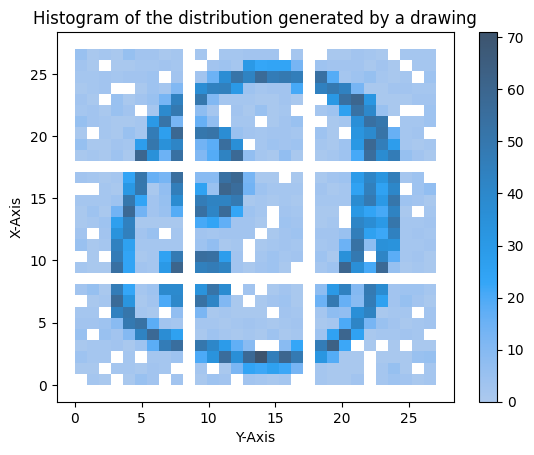

In [5]:
def plot_histogram(data: list[tuple[int, int]]):
    df = pd.DataFrame(data)
    sns.histplot(data=df, x=0, y=1, bins=30, cbar=True)
    plt.xlabel("Y-Axis")
    plt.ylabel("X-Axis")
    plt.title("Histogram of the distribution generated by a drawing")
    
data = np.array(faces[0].rvs(10_000))
plot_histogram(data)
plt.show()

Por lo que parece, sí tiene soporte distinto de 0.

Muestrear con respecto a una carita (la primera para simplificar)

In [6]:
n = 10
x = faces[0].rvs(size=n)
x

[(20, 23),
 (20, 10),
 (7, 19),
 (3, 9),
 (9, 7),
 (6, 16),
 (10, 18),
 (24, 19),
 (7, 4),
 (9, 11)]

Defino
\begin{equation}
\tilde\Lambda_n(m) = \prod_{i=1}^{n} f_m(x_i)
\end{equation}

A través de la función `lambda_n_tilde`

In [7]:
def lambda_n_tilde(mu: DistributionDraw, data: list[tuple[int, int]]):
    evaluations = []
    for i in range(len(data)):
        evaluations.append(mu.matrix[data[i]])
    return np.prod(evaluations)
lambda_n_tilde(mu=faces[0], data=x)

2.249690867335029e-27

# Metropolis Algorithm

En esta sección se implementa el *Metropolis Algorithm*. Este posee la siguiente matriz $R$:
\begin{equation}
R_{\mu, \nu} = (\text{degr}(\mu))^{-1} = \frac{1}{|\mathcal{M} - 1|}
\end{equation}
donde lo último es por la forma que posee el grafo escogido.

In [8]:
%%time
EPS = 1e-16  # Holgura para el determinador, para evitar dividir por 0

N = 10_000  # 10_000
mu = []

# Paso 1. Empezar con una distribución inicial mu^(0) \in M
current_face = int(rng.choice(n_faces))
mu.append(faces[current_face])  # mu^(0)

# Paso 2.
for i in range(N):
    # Paso a. muestrear u ~ U[0, 1]
    u = rng.uniform(low=0, high=1)

    # Paso b. muestrear mu^star de acuerdo a R partiendo desde mu^(i)
    possible_faces = list(range(n_faces))
    possible_faces.remove(current_face)
    next_face = int(rng.choice(possible_faces))
    mu_star = faces[next_face]

    # Paso c.
    # Empecemos calculando R
    R_mu_star_mu_i = 1 / (n_faces - 1)
    R_mu_i_mu_star = 1 / (n_faces - 1)
    # Luego calculamos la probabilidad de aceptación
    A_mu_i_mu_star = min(1, (lambda_n_tilde(mu_star, data=x) * R_mu_star_mu_i)
                            / (lambda_n_tilde(mu[i], data=x) * R_mu_i_mu_star + EPS))
    
    print(f"{i = }")
    print(f"{A_mu_i_mu_star = }")
    print(f"{u = }")
    
    if u < A_mu_i_mu_star:
        mu.append(mu_star)

    else:
        mu.append(mu[i])

i = 0
A_mu_i_mu_star = 3.623490225492183e-21
u = 0.5091827828619216
i = 1
A_mu_i_mu_star = 3.0504688118380673e-19
u = 0.043928143573384926
i = 2
A_mu_i_mu_star = 2.526310851016726e-22
u = 0.9352495547731959
i = 3
A_mu_i_mu_star = 1.1184919307988576e-22
u = 0.10316499273902846
i = 4
A_mu_i_mu_star = 3.875609416525891e-20
u = 0.7923256488409115
i = 5
A_mu_i_mu_star = 9.904617074812728e-23
u = 0.2654390627249239
i = 6
A_mu_i_mu_star = 8.056683618189443e-21
u = 0.16989517903018025
i = 7
A_mu_i_mu_star = 3.1218825061577683e-22
u = 0.28475027483379034
i = 8
A_mu_i_mu_star = 1.1092389041326246e-20
u = 0.9964349905642236
i = 9
A_mu_i_mu_star = 5.598450747376833e-19
u = 0.2145722952179573
i = 10
A_mu_i_mu_star = 7.689889228057829e-21
u = 0.9256914374814104
i = 11
A_mu_i_mu_star = 1.9220488912688635e-24
u = 0.16193069382035274
i = 12
A_mu_i_mu_star = 1.67127875795998e-20
u = 0.65045662764669
i = 13
A_mu_i_mu_star = 5.573958586367517e-24
u = 0.5768614980705188
i = 14
A_mu_i_mu_star = 4.1116545655

i = 120
A_mu_i_mu_star = 8.993392835755242e-23
u = 0.1188165758920744
i = 121
A_mu_i_mu_star = 1.3792328160863042e-20
u = 0.3048144107726547
i = 122
A_mu_i_mu_star = 2.818411966864224e-20
u = 0.000449526074255413
i = 123
A_mu_i_mu_star = 7.470356230397545e-22
u = 0.9209531874757245
i = 124
A_mu_i_mu_star = 2.3425397911700107e-19
u = 0.6824706006861725
i = 125
A_mu_i_mu_star = 2.2127207269251818e-21
u = 0.6288654771624883
i = 126
A_mu_i_mu_star = 7.027687653058736e-18
u = 0.6513877305621525
i = 127
A_mu_i_mu_star = 5.017291060821551e-24
u = 0.7693874172159795
i = 128
A_mu_i_mu_star = 1.6852077520813173e-21
u = 0.48870449455162324
i = 129
A_mu_i_mu_star = 1.1826511014140002e-18
u = 0.7016621021644194
i = 130
A_mu_i_mu_star = 1.8076253109302737e-19
u = 0.5115385502667199
i = 131
A_mu_i_mu_star = 3.9350924431034315e-20
u = 0.20555840605454934
i = 132
A_mu_i_mu_star = 4.902604983502529e-21
u = 0.3584972410593935
i = 133
A_mu_i_mu_star = 9.709955097636805e-22
u = 0.009284385423503183
i = 134

i = 248
A_mu_i_mu_star = 4.1637791343811456e-21
u = 0.8170116336327956
i = 249
A_mu_i_mu_star = 2.2530046094073867e-24
u = 0.7634265351621218
i = 250
A_mu_i_mu_star = 1.5405906879347266e-19
u = 0.635376650632306
i = 251
A_mu_i_mu_star = 6.41122056928783e-22
u = 0.6014929634649732
i = 252
A_mu_i_mu_star = 4.5200367910334186e-23
u = 0.19325930111436584
i = 253
A_mu_i_mu_star = 1.2630281931461132e-17
u = 0.6832061362281295
i = 254
A_mu_i_mu_star = 5.928536452683214e-21
u = 0.5762843206987531
i = 255
A_mu_i_mu_star = 6.1638926846398686e-21
u = 0.5678131455595449
i = 256
A_mu_i_mu_star = 2.5752816456711806e-20
u = 0.4405783001781288
i = 257
A_mu_i_mu_star = 1.9493572668221937e-20
u = 0.05417204350134375
i = 258
A_mu_i_mu_star = 2.2190287123564493e-23
u = 0.9002522101178897
i = 259
A_mu_i_mu_star = 6.918400555887648e-21
u = 0.8049468003915485
i = 260
A_mu_i_mu_star = 2.6122405256528276e-22
u = 0.15283158513241057
i = 261
A_mu_i_mu_star = 2.585058513254303e-20
u = 0.5059577570388295
i = 262
A

i = 373
A_mu_i_mu_star = 4.518784566864819e-18
u = 0.568933869819802
i = 374
A_mu_i_mu_star = 1.2606441341367255e-22
u = 0.4233059442193591
i = 375
A_mu_i_mu_star = 3.809570750185317e-21
u = 0.4006708898563054
i = 376
A_mu_i_mu_star = 1.637660101073181e-23
u = 0.677500849486126
i = 377
A_mu_i_mu_star = 5.543693598709433e-21
u = 0.7736901311234224
i = 378
A_mu_i_mu_star = 5.856478940867704e-26
u = 0.26143722470273545
i = 379
A_mu_i_mu_star = 1.2150961269307674e-21
u = 0.08686521852818196
i = 380
A_mu_i_mu_star = 4.63518280508252e-21
u = 0.41527643051770413
i = 381
A_mu_i_mu_star = 8.627064439904426e-20
u = 0.509223592096683
i = 382
A_mu_i_mu_star = 3.7539049097077666e-23
u = 0.4311378563692402
i = 383
A_mu_i_mu_star = 3.028203640251638e-20
u = 0.6838995770678498
i = 384
A_mu_i_mu_star = 3.5005183874804204e-20
u = 0.9720537986443055
i = 385
A_mu_i_mu_star = 5.940220044087435e-21
u = 0.13890390764923166
i = 386
A_mu_i_mu_star = 4.708503446892256e-17
u = 0.06324016340231398
i = 387
A_mu_i_

i = 507
A_mu_i_mu_star = 1.591085655269283e-22
u = 0.3022872154709001
i = 508
A_mu_i_mu_star = 4.2636132463008415e-19
u = 0.5855820134442432
i = 509
A_mu_i_mu_star = 1.4106296552510256e-20
u = 0.14952700881469905
i = 510
A_mu_i_mu_star = 1.9365275620067954e-20
u = 0.8855970205679587
i = 511
A_mu_i_mu_star = 6.756563997974091e-22
u = 0.47654751341364954
i = 512
A_mu_i_mu_star = 5.300130564500434e-17
u = 0.4847785064963399
i = 513
A_mu_i_mu_star = 4.5842339127386694e-17
u = 0.4649825764004636
i = 514
A_mu_i_mu_star = 1.4984124567791762e-18
u = 0.25936451218961754
i = 515
A_mu_i_mu_star = 2.4695944560438746e-21
u = 0.24980209930624997
i = 516
A_mu_i_mu_star = 3.093260237299346e-24
u = 0.8689920093192223
i = 517
A_mu_i_mu_star = 1.8082325628271326e-21
u = 0.7377548964496445
i = 518
A_mu_i_mu_star = 5.887339396227556e-22
u = 0.03022471118476666
i = 519
A_mu_i_mu_star = 4.0183240414651297e-22
u = 0.17541250419709298
i = 520
A_mu_i_mu_star = 2.6088441118166194e-21
u = 0.8162897702489879
i = 5

i = 624
A_mu_i_mu_star = 5.208729756705752e-19
u = 0.8188973939074429
i = 625
A_mu_i_mu_star = 5.689653772598924e-22
u = 0.4624061448243386
i = 626
A_mu_i_mu_star = 4.841320273458679e-20
u = 0.38344088127782827
i = 627
A_mu_i_mu_star = 3.207694068339261e-16
u = 0.9382974915177886
i = 628
A_mu_i_mu_star = 1.0417140803882178e-15
u = 0.7567174268235375
i = 629
A_mu_i_mu_star = 1.3099484990772485e-20
u = 0.9230043510911079
i = 630
A_mu_i_mu_star = 3.209688773285767e-20
u = 0.9476741468753561
i = 631
A_mu_i_mu_star = 3.9538190578983007e-22
u = 0.5550575977222759
i = 632
A_mu_i_mu_star = 3.664543270227028e-22
u = 0.9876405087679863
i = 633
A_mu_i_mu_star = 4.7352729344261895e-23
u = 0.21817920458030682
i = 634
A_mu_i_mu_star = 6.924658593766626e-19
u = 0.9631822977458351
i = 635
A_mu_i_mu_star = 5.1237375048908137e-23
u = 0.6891948218241696
i = 636
A_mu_i_mu_star = 4.349763917821382e-19
u = 0.1320497928413057
i = 637
A_mu_i_mu_star = 7.933348696979965e-24
u = 0.5132402490163293
i = 638
A_mu_

i = 754
A_mu_i_mu_star = 1.4282738697837847e-23
u = 0.7171338376013564
i = 755
A_mu_i_mu_star = 1.1004361184400864e-20
u = 0.02567268630734243
i = 756
A_mu_i_mu_star = 6.111256961465632e-22
u = 0.6828851202548609
i = 757
A_mu_i_mu_star = 7.814695184131178e-22
u = 0.12344235380044144
i = 758
A_mu_i_mu_star = 1.0167988298546476e-19
u = 0.10921516461119085
i = 759
A_mu_i_mu_star = 1.510715455661957e-21
u = 0.6906741530430963
i = 760
A_mu_i_mu_star = 8.620985932736535e-20
u = 0.14630436113648138
i = 761
A_mu_i_mu_star = 2.0855552554490207e-23
u = 0.2303001967590993
i = 762
A_mu_i_mu_star = 6.206382627476809e-24
u = 0.200352912260776
i = 763
A_mu_i_mu_star = 1.3492087173591554e-24
u = 0.0353753967242072
i = 764
A_mu_i_mu_star = 1.599254123796864e-19
u = 0.8763184242909228
i = 765
A_mu_i_mu_star = 4.730342165193885e-21
u = 0.1848190008964724
i = 766
A_mu_i_mu_star = 3.3703451037455146e-16
u = 0.18855757144364094
i = 767
A_mu_i_mu_star = 1.478434791341223e-22
u = 0.7195345389617299
i = 768
A_

i = 883
A_mu_i_mu_star = 2.5942889590404044e-18
u = 0.0354469349997697
i = 884
A_mu_i_mu_star = 1.410054000840278e-20
u = 0.4781286571011477
i = 885
A_mu_i_mu_star = 6.418088845745817e-24
u = 0.507682390862889
i = 886
A_mu_i_mu_star = 2.647836098607155e-18
u = 0.6128056746614275
i = 887
A_mu_i_mu_star = 7.798092570751382e-20
u = 0.1812058748383879
i = 888
A_mu_i_mu_star = 1.394733141150542e-18
u = 0.19570951518932744
i = 889
A_mu_i_mu_star = 2.672447653081887e-18
u = 0.6966635999901375
i = 890
A_mu_i_mu_star = 1.3045136538262078e-20
u = 0.7361010990726155
i = 891
A_mu_i_mu_star = 6.423362824242982e-23
u = 0.05724816959164969
i = 892
A_mu_i_mu_star = 6.1522900961229796e-24
u = 0.9669585789814206
i = 893
A_mu_i_mu_star = 2.142808870180893e-21
u = 0.053619514706363613
i = 894
A_mu_i_mu_star = 4.267504803660296e-18
u = 0.04039821885562056
i = 895
A_mu_i_mu_star = 4.576950145683593e-20
u = 0.14665332097079997
i = 896
A_mu_i_mu_star = 1.2810564308921774e-20
u = 0.1575133976840526
i = 897
A_m

i = 1008
A_mu_i_mu_star = 3.762462851114535e-24
u = 0.015687527283303915
i = 1009
A_mu_i_mu_star = 3.7827003875523576e-20
u = 0.8984836357454766
i = 1010
A_mu_i_mu_star = 2.2052332653309973e-19
u = 0.07582321014241111
i = 1011
A_mu_i_mu_star = 2.1803917236926854e-22
u = 0.7236110778130539
i = 1012
A_mu_i_mu_star = 3.2171839886062163e-22
u = 0.6023070734286845
i = 1013
A_mu_i_mu_star = 1.4432768845442183e-22
u = 0.5776708001561233
i = 1014
A_mu_i_mu_star = 3.2518559935427298e-21
u = 0.05949637182278256
i = 1015
A_mu_i_mu_star = 1.4893791772562737e-16
u = 0.7272886498356969
i = 1016
A_mu_i_mu_star = 2.164435422449989e-22
u = 0.24184410070647755
i = 1017
A_mu_i_mu_star = 7.496254404921317e-21
u = 0.49883659382335876
i = 1018
A_mu_i_mu_star = 7.665870909859576e-19
u = 0.7898395605500256
i = 1019
A_mu_i_mu_star = 3.514210088450801e-25
u = 0.8073780237790886
i = 1020
A_mu_i_mu_star = 5.862431813336339e-20
u = 0.04956812077470496
i = 1021
A_mu_i_mu_star = 2.5654739726582e-25
u = 0.42787316123

i = 1137
A_mu_i_mu_star = 5.870654114509393e-22
u = 0.309612869707926
i = 1138
A_mu_i_mu_star = 1.2012378095329822e-19
u = 0.5773905923516431
i = 1139
A_mu_i_mu_star = 6.873328379689549e-16
u = 0.9834222587594326
i = 1140
A_mu_i_mu_star = 1.5932563925171203e-18
u = 0.5478807422402548
i = 1141
A_mu_i_mu_star = 3.629119374626481e-19
u = 0.5925376488712538
i = 1142
A_mu_i_mu_star = 9.64670146873579e-24
u = 0.046953247491470784
i = 1143
A_mu_i_mu_star = 4.645144364373355e-19
u = 0.052104535687826026
i = 1144
A_mu_i_mu_star = 5.621917868254123e-22
u = 0.6924737894439191
i = 1145
A_mu_i_mu_star = 9.610302831996303e-24
u = 0.7001757858031274
i = 1146
A_mu_i_mu_star = 3.868609974913555e-22
u = 0.8579721410057863
i = 1147
A_mu_i_mu_star = 5.606532401503951e-21
u = 0.3771624259697449
i = 1148
A_mu_i_mu_star = 1.8930250885094355e-24
u = 0.11815963442563682
i = 1149
A_mu_i_mu_star = 6.700255428913482e-22
u = 0.8364546986354818
i = 1150
A_mu_i_mu_star = 7.19253602026934e-16
u = 0.8226755261437314
i

i = 1252
A_mu_i_mu_star = 1.5889006998803117e-22
u = 0.011568714660440294
i = 1253
A_mu_i_mu_star = 2.325985098609209e-20
u = 0.4865132494033523
i = 1254
A_mu_i_mu_star = 2.8304939752997417e-19
u = 0.598861703728065
i = 1255
A_mu_i_mu_star = 4.630950238250592e-19
u = 0.798169969707828
i = 1256
A_mu_i_mu_star = 3.8275658211979294e-22
u = 0.16377272659174524
i = 1257
A_mu_i_mu_star = 1.0143443545692235e-22
u = 0.34261038116190246
i = 1258
A_mu_i_mu_star = 3.6931700301374154e-21
u = 0.3832198898062551
i = 1259
A_mu_i_mu_star = 6.784459148826114e-23
u = 0.9518682998174518
i = 1260
A_mu_i_mu_star = 1.7899672060495922e-23
u = 0.4232821086657721
i = 1261
A_mu_i_mu_star = 1.0394250153646119e-20
u = 0.45709137160758284
i = 1262
A_mu_i_mu_star = 1.460582560308114e-23
u = 0.2785065576875697
i = 1263
A_mu_i_mu_star = 1.9600691359021067e-20
u = 0.7147521617493207
i = 1264
A_mu_i_mu_star = 1.012352729158251e-20
u = 0.8128320197331531
i = 1265
A_mu_i_mu_star = 4.201938722039632e-24
u = 0.405073222478

i = 1373
A_mu_i_mu_star = 8.426883547783323e-21
u = 0.7052573945651862
i = 1374
A_mu_i_mu_star = 3.2466390283230176e-17
u = 0.36532320583048983
i = 1375
A_mu_i_mu_star = 1.3378588450821977e-22
u = 0.043126566762483276
i = 1376
A_mu_i_mu_star = 4.8054496404412934e-23
u = 0.9949381428236241
i = 1377
A_mu_i_mu_star = 1.8088585407475745e-20
u = 0.4298849568221589
i = 1378
A_mu_i_mu_star = 1.0050055987285003e-20
u = 0.1262254238089625
i = 1379
A_mu_i_mu_star = 5.8671364267222824e-24
u = 0.3924543432677957
i = 1380
A_mu_i_mu_star = 8.215741148265475e-20
u = 0.8766954816574721
i = 1381
A_mu_i_mu_star = 3.6199705609276895e-20
u = 0.3235915778697842
i = 1382
A_mu_i_mu_star = 1.2617585832592844e-18
u = 0.8861601715577907
i = 1383
A_mu_i_mu_star = 2.156231970569289e-18
u = 0.7668774661532277
i = 1384
A_mu_i_mu_star = 4.4295780988510025e-21
u = 0.15257561456002255
i = 1385
A_mu_i_mu_star = 1.7357600326579234e-20
u = 0.07300269257056347
i = 1386
A_mu_i_mu_star = 3.3077838037792697e-15
u = 0.5002756

i = 1496
A_mu_i_mu_star = 9.663705253218741e-20
u = 0.9046435780864176
i = 1497
A_mu_i_mu_star = 1.9306430159426834e-19
u = 0.7039971134546849
i = 1498
A_mu_i_mu_star = 1.2385320709201504e-19
u = 0.3120433743548727
i = 1499
A_mu_i_mu_star = 1.835810175799141e-20
u = 0.7633184605955448
i = 1500
A_mu_i_mu_star = 2.3823734108049954e-19
u = 0.46879782285811167
i = 1501
A_mu_i_mu_star = 5.548189089475431e-20
u = 0.4587990610460554
i = 1502
A_mu_i_mu_star = 5.778882477371618e-24
u = 0.7213914378982609
i = 1503
A_mu_i_mu_star = 1.059208186805379e-21
u = 0.10300633052136965
i = 1504
A_mu_i_mu_star = 3.99095675481316e-21
u = 0.16995582745936177
i = 1505
A_mu_i_mu_star = 3.9730854269189743e-22
u = 0.046532809577156
i = 1506
A_mu_i_mu_star = 2.860029676155272e-20
u = 0.8693349363117417
i = 1507
A_mu_i_mu_star = 2.522176053952382e-21
u = 0.17614766478046118
i = 1508
A_mu_i_mu_star = 4.6837157938585266e-18
u = 0.13809478822040622
i = 1509
A_mu_i_mu_star = 4.92458635841126e-22
u = 0.7355451016577587

i = 1620
A_mu_i_mu_star = 7.554246036745955e-20
u = 0.6423054796934369
i = 1621
A_mu_i_mu_star = 8.757494496754062e-22
u = 0.4318963464956951
i = 1622
A_mu_i_mu_star = 3.491531021045196e-21
u = 0.48042220881200615
i = 1623
A_mu_i_mu_star = 6.74116750244775e-22
u = 0.16299427878615658
i = 1624
A_mu_i_mu_star = 3.512924410610745e-21
u = 0.60572907246576
i = 1625
A_mu_i_mu_star = 2.6851625396378505e-23
u = 0.8100713681262028
i = 1626
A_mu_i_mu_star = 6.871226053411604e-22
u = 0.278648533027529
i = 1627
A_mu_i_mu_star = 3.12742450415261e-19
u = 0.8363953592357555
i = 1628
A_mu_i_mu_star = 7.646146974245348e-22
u = 0.70670916405935
i = 1629
A_mu_i_mu_star = 5.212175259741414e-22
u = 0.5280845714063456
i = 1630
A_mu_i_mu_star = 1.970659194195036e-16
u = 0.22778350747153586
i = 1631
A_mu_i_mu_star = 1.0475448858063073e-18
u = 0.4016920253529206
i = 1632
A_mu_i_mu_star = 3.677638545492218e-22
u = 0.13296090196868116
i = 1633
A_mu_i_mu_star = 2.858380533329472e-23
u = 0.8081094930162147
i = 163

i = 1740
A_mu_i_mu_star = 5.55094833614924e-22
u = 0.778063647164877
i = 1741
A_mu_i_mu_star = 6.149379941682629e-22
u = 0.7687109276653382
i = 1742
A_mu_i_mu_star = 2.981981217686836e-21
u = 0.9396988419588779
i = 1743
A_mu_i_mu_star = 1.0249006570734682e-22
u = 0.5838215033826768
i = 1744
A_mu_i_mu_star = 7.171446429560861e-21
u = 0.27371044242286724
i = 1745
A_mu_i_mu_star = 2.1500289462907117e-20
u = 0.28173591984167345
i = 1746
A_mu_i_mu_star = 2.2711450024393937e-20
u = 0.3347674216396055
i = 1747
A_mu_i_mu_star = 1.5248583296556956e-21
u = 0.7287107451466779
i = 1748
A_mu_i_mu_star = 8.41103414011395e-20
u = 0.43930743677875883
i = 1749
A_mu_i_mu_star = 4.389619640551529e-21
u = 0.09732564287964196
i = 1750
A_mu_i_mu_star = 5.886007638252881e-23
u = 0.009523031695485629
i = 1751
A_mu_i_mu_star = 9.112363932086108e-19
u = 0.7870035212722968
i = 1752
A_mu_i_mu_star = 2.7352258599591173e-23
u = 0.4897322040086549
i = 1753
A_mu_i_mu_star = 2.4128954595625694e-20
u = 0.56944216057768

i = 1864
A_mu_i_mu_star = 4.471870322505039e-19
u = 0.9206872007858861
i = 1865
A_mu_i_mu_star = 2.4908114488097754e-20
u = 0.9486558601572134
i = 1866
A_mu_i_mu_star = 3.374117861652144e-22
u = 0.7169499079603164
i = 1867
A_mu_i_mu_star = 1.6695194174689045e-22
u = 0.6630139069348495
i = 1868
A_mu_i_mu_star = 4.291706745945052e-22
u = 0.2655650763462797
i = 1869
A_mu_i_mu_star = 8.878365812652911e-22
u = 0.2067667296794684
i = 1870
A_mu_i_mu_star = 5.480985300231914e-20
u = 0.953053716545225
i = 1871
A_mu_i_mu_star = 1.3367463170617167e-22
u = 0.8456016389583383
i = 1872
A_mu_i_mu_star = 3.3235990219973903e-19
u = 0.5300315310993231
i = 1873
A_mu_i_mu_star = 3.202481192041961e-22
u = 0.1922661215866619
i = 1874
A_mu_i_mu_star = 2.5114185786069567e-20
u = 0.06500324901488452
i = 1875
A_mu_i_mu_star = 1.1855756785411972e-18
u = 0.6426065009168366
i = 1876
A_mu_i_mu_star = 1.9777093055147434e-23
u = 0.8385016208034435
i = 1877
A_mu_i_mu_star = 3.3599116382632353e-21
u = 0.871551813427254

i = 1983
A_mu_i_mu_star = 2.8460132086530488e-18
u = 0.6927262037835346
i = 1984
A_mu_i_mu_star = 1.6056275181370903e-21
u = 0.034182442766647725
i = 1985
A_mu_i_mu_star = 1.03035286068356e-21
u = 0.6276794376753354
i = 1986
A_mu_i_mu_star = 2.7553302926720257e-17
u = 0.47413775994138385
i = 1987
A_mu_i_mu_star = 1.5298939948427722e-18
u = 0.4239811288833696
i = 1988
A_mu_i_mu_star = 3.0159524692942055e-20
u = 0.19035610024746197
i = 1989
A_mu_i_mu_star = 3.3422217365830144e-22
u = 0.8026499364449822
i = 1990
A_mu_i_mu_star = 1.6180653822133004e-20
u = 0.8871962609364799
i = 1991
A_mu_i_mu_star = 2.6377863141038585e-20
u = 0.35466827294649084
i = 1992
A_mu_i_mu_star = 1.6872399756200693e-21
u = 0.5444663315246878
i = 1993
A_mu_i_mu_star = 5.24608417982649e-23
u = 0.38562523485979217
i = 1994
A_mu_i_mu_star = 7.482337416934426e-17
u = 0.7866546246034223
i = 1995
A_mu_i_mu_star = 2.9265489060071343e-19
u = 0.4826907902744818
i = 1996
A_mu_i_mu_star = 7.084026201016538e-24
u = 0.577418970

i = 2112
A_mu_i_mu_star = 6.4537160097867235e-24
u = 0.9589391371657489
i = 2113
A_mu_i_mu_star = 6.838651228347415e-22
u = 0.4633797406331909
i = 2114
A_mu_i_mu_star = 2.7427015634877103e-22
u = 0.16399972606481883
i = 2115
A_mu_i_mu_star = 6.619595318923976e-20
u = 0.18346606723001224
i = 2116
A_mu_i_mu_star = 8.484412120576014e-23
u = 0.2698756426168226
i = 2117
A_mu_i_mu_star = 1.0256174307101443e-20
u = 0.18493785561126042
i = 2118
A_mu_i_mu_star = 7.72614193238429e-19
u = 0.07627067030716383
i = 2119
A_mu_i_mu_star = 3.102935567321117e-20
u = 0.7531683854134263
i = 2120
A_mu_i_mu_star = 2.8318337592624215e-22
u = 0.9784191533076348
i = 2121
A_mu_i_mu_star = 2.2094005362078796e-24
u = 0.1831211274791248
i = 2122
A_mu_i_mu_star = 1.7945137240980508e-19
u = 0.37490861948233345
i = 2123
A_mu_i_mu_star = 2.9948441253977605e-17
u = 0.5001527927368299
i = 2124
A_mu_i_mu_star = 2.948573340645305e-18
u = 0.8347702099641873
i = 2125
A_mu_i_mu_star = 2.1502743088189333e-20
u = 0.00995633086

i = 2245
A_mu_i_mu_star = 8.49340592697001e-20
u = 0.7930659710405652
i = 2246
A_mu_i_mu_star = 4.78103788601154e-19
u = 0.259598670800521
i = 2247
A_mu_i_mu_star = 1.3783680675793638e-21
u = 0.45083484597216006
i = 2248
A_mu_i_mu_star = 1.1475533974013267e-19
u = 0.024309457211191376
i = 2249
A_mu_i_mu_star = 2.251684258989341e-21
u = 0.6590126278649572
i = 2250
A_mu_i_mu_star = 2.313930765828219e-19
u = 0.2481168805635673
i = 2251
A_mu_i_mu_star = 4.421181877552934e-20
u = 0.8471039472996119
i = 2252
A_mu_i_mu_star = 2.8225820122273984e-23
u = 0.9946576772125906
i = 2253
A_mu_i_mu_star = 5.500131131457816e-21
u = 0.7933578269389671
i = 2254
A_mu_i_mu_star = 2.0428882301748663e-18
u = 0.7733322487976717
i = 2255
A_mu_i_mu_star = 9.500985434204503e-22
u = 0.10592489895062163
i = 2256
A_mu_i_mu_star = 8.892100077605857e-21
u = 0.9150787726144635
i = 2257
A_mu_i_mu_star = 1.7285062498965027e-20
u = 0.13819718803980208
i = 2258
A_mu_i_mu_star = 7.344040854043757e-22
u = 0.6099110115559309

i = 2362
A_mu_i_mu_star = 2.194930332389306e-17
u = 0.9273155245090483
i = 2363
A_mu_i_mu_star = 1.2389926015492506e-19
u = 0.1184390852842464
i = 2364
A_mu_i_mu_star = 1.214376787639031e-21
u = 0.9928513586443369
i = 2365
A_mu_i_mu_star = 5.462812381089391e-20
u = 0.8526192490484263
i = 2366
A_mu_i_mu_star = 1.1571335831383055e-24
u = 0.022460945440901936
i = 2367
A_mu_i_mu_star = 5.227127494794998e-20
u = 0.06837744536824142
i = 2368
A_mu_i_mu_star = 1.5748407698210332e-21
u = 0.37644485419096874
i = 2369
A_mu_i_mu_star = 3.031132146931179e-19
u = 0.6684318774590476
i = 2370
A_mu_i_mu_star = 1.241706136073646e-22
u = 0.4221841775250891
i = 2371
A_mu_i_mu_star = 2.0576068142515444e-20
u = 0.14338175070077952
i = 2372
A_mu_i_mu_star = 7.7736961560523445e-22
u = 0.8710484423186046
i = 2373
A_mu_i_mu_star = 1.6065524704356222e-19
u = 0.3310857790319788
i = 2374
A_mu_i_mu_star = 5.527171741030277e-19
u = 0.9591314171847817
i = 2375
A_mu_i_mu_star = 7.71560688463959e-23
u = 0.6806769089738

i = 2495
A_mu_i_mu_star = 4.095457902238336e-24
u = 0.0930202570243659
i = 2496
A_mu_i_mu_star = 1.1395342895065388e-18
u = 0.8657898463226186
i = 2497
A_mu_i_mu_star = 8.861959736972096e-23
u = 0.9394133130222055
i = 2498
A_mu_i_mu_star = 1.891449658803508e-19
u = 0.1926439818409379
i = 2499
A_mu_i_mu_star = 3.8256811802307057e-22
u = 0.4203294965099348
i = 2500
A_mu_i_mu_star = 4.329533839142235e-18
u = 0.5195693781625502
i = 2501
A_mu_i_mu_star = 3.492360900283576e-22
u = 0.2743530801829511
i = 2502
A_mu_i_mu_star = 1.3608443795642836e-22
u = 0.655587631346092
i = 2503
A_mu_i_mu_star = 2.554284889176626e-21
u = 0.6217941509966394
i = 2504
A_mu_i_mu_star = 5.981019315193394e-18
u = 0.3772849831975811
i = 2505
A_mu_i_mu_star = 4.224156940142751e-24
u = 0.33645683849989216
i = 2506
A_mu_i_mu_star = 1.4768382071361337e-21
u = 0.9511764854896684
i = 2507
A_mu_i_mu_star = 1.1623017306970168e-17
u = 0.3952451031443228
i = 2508
A_mu_i_mu_star = 4.843549542660743e-20
u = 0.5228431871665385
i

i = 2611
A_mu_i_mu_star = 1.8253805192997565e-18
u = 0.3245828574405618
i = 2612
A_mu_i_mu_star = 1.864015465920631e-21
u = 0.5878855149060273
i = 2613
A_mu_i_mu_star = 2.0299531798075672e-21
u = 0.8481848353039325
i = 2614
A_mu_i_mu_star = 1.9186194958452748e-22
u = 0.5823313901318106
i = 2615
A_mu_i_mu_star = 2.1125710793597758e-19
u = 0.47735649484318043
i = 2616
A_mu_i_mu_star = 3.921841457558779e-22
u = 0.41499217609851824
i = 2617
A_mu_i_mu_star = 9.5216185220314e-22
u = 0.8519396047299149
i = 2618
A_mu_i_mu_star = 1.0558585619999199e-24
u = 0.6926250463809654
i = 2619
A_mu_i_mu_star = 6.279587542694566e-22
u = 0.8929708990996522
i = 2620
A_mu_i_mu_star = 5.575704467523087e-19
u = 0.3426081425159513
i = 2621
A_mu_i_mu_star = 3.343530737421642e-19
u = 0.7063390029507729
i = 2622
A_mu_i_mu_star = 3.24484402210154e-19
u = 0.058165079451809376
i = 2623
A_mu_i_mu_star = 2.2578597642240182e-20
u = 0.7913817396448508
i = 2624
A_mu_i_mu_star = 7.539908524740875e-20
u = 0.0229309389155975

i = 2728
A_mu_i_mu_star = 8.94008677539385e-17
u = 0.9914597511748098
i = 2729
A_mu_i_mu_star = 5.926290811118484e-21
u = 0.8630158925673534
i = 2730
A_mu_i_mu_star = 1.9028903254988414e-20
u = 0.7688190125100985
i = 2731
A_mu_i_mu_star = 6.4152756587699385e-22
u = 0.2222276435962557
i = 2732
A_mu_i_mu_star = 4.9630701899035666e-23
u = 0.6971681286006974
i = 2733
A_mu_i_mu_star = 1.7374063590715906e-17
u = 0.9689013391845618
i = 2734
A_mu_i_mu_star = 1.7360844406048788e-17
u = 0.4958364210333366
i = 2735
A_mu_i_mu_star = 2.871692018947768e-21
u = 0.22016852895105443
i = 2736
A_mu_i_mu_star = 4.0520393613983815e-21
u = 0.06301860769564438
i = 2737
A_mu_i_mu_star = 7.55979409559331e-23
u = 0.8585858956268387
i = 2738
A_mu_i_mu_star = 5.2348904589509194e-21
u = 0.6835245845933516
i = 2739
A_mu_i_mu_star = 3.543645695636949e-21
u = 0.273221701454167
i = 2740
A_mu_i_mu_star = 8.08847992324247e-20
u = 0.2815584400997575
i = 2741
A_mu_i_mu_star = 2.603326877432972e-21
u = 0.4000706680269044
i

i = 2844
A_mu_i_mu_star = 8.487877126017233e-23
u = 0.17414271333279996
i = 2845
A_mu_i_mu_star = 2.642914074048535e-17
u = 0.6365485996930432
i = 2846
A_mu_i_mu_star = 6.1268241872088e-19
u = 0.4506355901137111
i = 2847
A_mu_i_mu_star = 2.4113272683457675e-18
u = 0.18013798985405693
i = 2848
A_mu_i_mu_star = 3.3037931876757914e-22
u = 0.6979409896782558
i = 2849
A_mu_i_mu_star = 2.0542942156560398e-17
u = 0.5322901390021636
i = 2850
A_mu_i_mu_star = 5.43343856460648e-22
u = 0.5568647853571268
i = 2851
A_mu_i_mu_star = 1.4021226257130426e-18
u = 0.10013342214702037
i = 2852
A_mu_i_mu_star = 4.0593051499023904e-22
u = 0.3723578427927129
i = 2853
A_mu_i_mu_star = 7.422048413420153e-18
u = 0.8834253925406446
i = 2854
A_mu_i_mu_star = 3.277874887871582e-16
u = 0.598469868625797
i = 2855
A_mu_i_mu_star = 4.586729981045858e-18
u = 0.8747789879039839
i = 2856
A_mu_i_mu_star = 4.498416356772971e-21
u = 0.883703520070732
i = 2857
A_mu_i_mu_star = 1.751335334353452e-20
u = 0.13646131252663973
i 

i = 2967
A_mu_i_mu_star = 2.093684694111131e-20
u = 0.6102396819679363
i = 2968
A_mu_i_mu_star = 1.2838021183200534e-17
u = 0.2523176168092264
i = 2969
A_mu_i_mu_star = 6.833354104746131e-16
u = 0.7673713758229969
i = 2970
A_mu_i_mu_star = 7.276893130568605e-22
u = 0.13064961263145092
i = 2971
A_mu_i_mu_star = 1.609386602176192e-21
u = 0.20017285240906635
i = 2972
A_mu_i_mu_star = 3.7143517252302143e-17
u = 0.9360415078387312
i = 2973
A_mu_i_mu_star = 1.8538154138858368e-20
u = 0.32634986360423335
i = 2974
A_mu_i_mu_star = 1.092114482127415e-21
u = 0.1416257376588499
i = 2975
A_mu_i_mu_star = 3.973619317109145e-20
u = 0.032171823650812836
i = 2976
A_mu_i_mu_star = 2.3593754782756646e-21
u = 0.797153400969704
i = 2977
A_mu_i_mu_star = 5.799104530869444e-21
u = 0.45043578058900335
i = 2978
A_mu_i_mu_star = 2.890800148167113e-21
u = 0.0475293213607374
i = 2979
A_mu_i_mu_star = 5.081032304290671e-22
u = 0.46972286414476394
i = 2980
A_mu_i_mu_star = 1.1817190414155082e-17
u = 0.674722217653

i = 3099
A_mu_i_mu_star = 3.8152863259080533e-23
u = 0.251529150599892
i = 3100
A_mu_i_mu_star = 7.462144520437097e-19
u = 0.4730758868067968
i = 3101
A_mu_i_mu_star = 2.6789945253737613e-19
u = 0.7904309573735042
i = 3102
A_mu_i_mu_star = 6.7178301336641845e-22
u = 0.015415980283715713
i = 3103
A_mu_i_mu_star = 4.0173516411624494e-19
u = 0.48268739032679564
i = 3104
A_mu_i_mu_star = 1.5075543864513343e-19
u = 0.8267863804814273
i = 3105
A_mu_i_mu_star = 1.0083873518359075e-19
u = 0.11365808498470065
i = 3106
A_mu_i_mu_star = 2.3191504267066336e-23
u = 0.45996524279482887
i = 3107
A_mu_i_mu_star = 2.201088711176253e-21
u = 0.1951840554004145
i = 3108
A_mu_i_mu_star = 2.3387474055805547e-21
u = 0.4606984244467053
i = 3109
A_mu_i_mu_star = 2.8721325941967093e-21
u = 0.9525226109172888
i = 3110
A_mu_i_mu_star = 2.1917493652275314e-22
u = 0.5767320482685504
i = 3111
A_mu_i_mu_star = 1.0512061856167537e-21
u = 0.7203996096439838
i = 3112
A_mu_i_mu_star = 2.9373678063616754e-19
u = 0.6364621

i = 3218
A_mu_i_mu_star = 2.7228503451819716e-23
u = 0.52711905375959
i = 3219
A_mu_i_mu_star = 5.43944247501712e-21
u = 0.04928580302250252
i = 3220
A_mu_i_mu_star = 4.289182531805595e-22
u = 0.4147227619375855
i = 3221
A_mu_i_mu_star = 4.896628367733953e-25
u = 0.3349519234335785
i = 3222
A_mu_i_mu_star = 4.2140715559314597e-22
u = 0.03791016704380623
i = 3223
A_mu_i_mu_star = 1.2496975759749957e-18
u = 0.16766866973689132
i = 3224
A_mu_i_mu_star = 2.217654664654343e-19
u = 0.44049176852980043
i = 3225
A_mu_i_mu_star = 3.5894552879743936e-22
u = 0.24683476237895274
i = 3226
A_mu_i_mu_star = 2.2505752410630694e-19
u = 0.5975736737824379
i = 3227
A_mu_i_mu_star = 5.1132069051620145e-18
u = 0.7438719778032219
i = 3228
A_mu_i_mu_star = 1.8399525270025697e-18
u = 0.2761800952275212
i = 3229
A_mu_i_mu_star = 2.0361904916490694e-21
u = 0.854444836366964
i = 3230
A_mu_i_mu_star = 8.816970581544401e-21
u = 0.6146667010074238
i = 3231
A_mu_i_mu_star = 1.4824658041263265e-18
u = 0.2128484517164

i = 3343
A_mu_i_mu_star = 1.0482348801530425e-20
u = 0.7075581882221293
i = 3344
A_mu_i_mu_star = 2.9775411527039805e-19
u = 0.466236900694864
i = 3345
A_mu_i_mu_star = 2.4457562431292944e-19
u = 0.6607049978861596
i = 3346
A_mu_i_mu_star = 7.990296757297227e-21
u = 0.8850976071230604
i = 3347
A_mu_i_mu_star = 7.392655337115088e-18
u = 0.47384464038782836
i = 3348
A_mu_i_mu_star = 1.0112978010423839e-21
u = 0.21458203741288162
i = 3349
A_mu_i_mu_star = 1.2723167727225005e-20
u = 0.8460565588592908
i = 3350
A_mu_i_mu_star = 3.8233833350004035e-21
u = 0.8691303619968337
i = 3351
A_mu_i_mu_star = 3.6394752184028684e-22
u = 0.05558808560398476
i = 3352
A_mu_i_mu_star = 2.6415834799393844e-21
u = 0.800176227445629
i = 3353
A_mu_i_mu_star = 1.5852064492520098e-21
u = 0.407615376822399
i = 3354
A_mu_i_mu_star = 9.487356916326413e-22
u = 0.10029883452578314
i = 3355
A_mu_i_mu_star = 8.744367941378794e-20
u = 0.5115422264351864
i = 3356
A_mu_i_mu_star = 6.298951647469093e-20
u = 0.8908685972372

i = 3464
A_mu_i_mu_star = 1.1257982040681726e-25
u = 0.8596161262583144
i = 3465
A_mu_i_mu_star = 5.241690154832748e-21
u = 0.3137474957639904
i = 3466
A_mu_i_mu_star = 1.4317559874692526e-17
u = 0.7519998644414946
i = 3467
A_mu_i_mu_star = 2.063368422015991e-21
u = 0.23919454199125745
i = 3468
A_mu_i_mu_star = 6.890331399117763e-21
u = 0.6751620876684642
i = 3469
A_mu_i_mu_star = 2.9382982512575106e-19
u = 0.2744284126222738
i = 3470
A_mu_i_mu_star = 3.2240577179344346e-19
u = 0.435777727256493
i = 3471
A_mu_i_mu_star = 6.151961706811785e-25
u = 0.7735095683710361
i = 3472
A_mu_i_mu_star = 3.804365744859014e-20
u = 0.5010266114566932
i = 3473
A_mu_i_mu_star = 6.978837440734827e-21
u = 0.1843408135638115
i = 3474
A_mu_i_mu_star = 4.134250047670061e-23
u = 0.6803688629709497
i = 3475
A_mu_i_mu_star = 1.2366452792379454e-21
u = 0.5011265086935832
i = 3476
A_mu_i_mu_star = 4.168688384424645e-19
u = 0.3150581890551687
i = 3477
A_mu_i_mu_star = 8.842069606099157e-23
u = 0.3133226793003714
i

i = 3596
A_mu_i_mu_star = 4.354246109701895e-19
u = 0.8944624815519232
i = 3597
A_mu_i_mu_star = 1.1864621020302448e-23
u = 0.2408752256465332
i = 3598
A_mu_i_mu_star = 7.484900343038969e-21
u = 0.3586233926795297
i = 3599
A_mu_i_mu_star = 1.1632194614113234e-19
u = 0.1461086835080887
i = 3600
A_mu_i_mu_star = 9.444115392959461e-21
u = 0.7174466968694084
i = 3601
A_mu_i_mu_star = 1.2996902521122379e-23
u = 0.7961916546491633
i = 3602
A_mu_i_mu_star = 7.820551709361321e-22
u = 0.24281917477268689
i = 3603
A_mu_i_mu_star = 2.2838436266558343e-23
u = 0.14065663802023654
i = 3604
A_mu_i_mu_star = 3.013206641552849e-19
u = 0.8290191217744813
i = 3605
A_mu_i_mu_star = 1.2847835195768778e-17
u = 0.3305153286007685
i = 3606
A_mu_i_mu_star = 3.4145693553278063e-18
u = 0.6600607021214705
i = 3607
A_mu_i_mu_star = 5.958491383767411e-23
u = 0.2000630708531641
i = 3608
A_mu_i_mu_star = 6.4123196266410004e-21
u = 0.014880050025618874
i = 3609
A_mu_i_mu_star = 4.909209123689271e-23
u = 0.508849855621

i = 3716
A_mu_i_mu_star = 7.920782718709768e-20
u = 0.6250609939521135
i = 3717
A_mu_i_mu_star = 3.7210685250498443e-20
u = 0.1008575948836069
i = 3718
A_mu_i_mu_star = 1.2434689172652995e-20
u = 0.13717786234686447
i = 3719
A_mu_i_mu_star = 9.684486691782937e-20
u = 0.797601295557767
i = 3720
A_mu_i_mu_star = 1.6018726071636932e-21
u = 0.0028299367165864897
i = 3721
A_mu_i_mu_star = 1.1139897086012658e-20
u = 0.5429036472281525
i = 3722
A_mu_i_mu_star = 5.968618601646307e-21
u = 0.6430764029925051
i = 3723
A_mu_i_mu_star = 9.671051177051286e-22
u = 0.034844055486996095
i = 3724
A_mu_i_mu_star = 2.579479705750039e-24
u = 0.34936810509535676
i = 3725
A_mu_i_mu_star = 9.077485471543327e-23
u = 0.6885380961614872
i = 3726
A_mu_i_mu_star = 8.271798018379964e-20
u = 0.2782635792102547
i = 3727
A_mu_i_mu_star = 1.4490314258509375e-18
u = 0.2160675445628959
i = 3728
A_mu_i_mu_star = 1.2502808108560886e-17
u = 0.027112736133802606
i = 3729
A_mu_i_mu_star = 4.031153745369686e-21
u = 0.556783331

i = 3846
A_mu_i_mu_star = 2.577664457019934e-19
u = 0.019510265335404342
i = 3847
A_mu_i_mu_star = 5.960139860013216e-21
u = 0.5868230781613851
i = 3848
A_mu_i_mu_star = 1.3662206961858739e-18
u = 0.21531700217248884
i = 3849
A_mu_i_mu_star = 3.3755807904104065e-18
u = 0.4904475335875007
i = 3850
A_mu_i_mu_star = 1.3163146532784273e-24
u = 0.9994776140287939
i = 3851
A_mu_i_mu_star = 1.3406801152437572e-20
u = 0.3321144411656285
i = 3852
A_mu_i_mu_star = 8.160547780010926e-23
u = 0.7847781680504067
i = 3853
A_mu_i_mu_star = 5.094112190410059e-18
u = 0.7127783435934174
i = 3854
A_mu_i_mu_star = 1.0170250827558498e-18
u = 0.9413257368665511
i = 3855
A_mu_i_mu_star = 6.574193551241196e-21
u = 0.18917783096636642
i = 3856
A_mu_i_mu_star = 1.096027688683502e-20
u = 0.6868169919623913
i = 3857
A_mu_i_mu_star = 1.4315905524493601e-18
u = 0.04502427543041465
i = 3858
A_mu_i_mu_star = 8.966710208362115e-20
u = 0.004883440001247741
i = 3859
A_mu_i_mu_star = 3.039307147751994e-20
u = 0.9140884762

i = 3964
A_mu_i_mu_star = 2.541630820615302e-21
u = 0.651100016701223
i = 3965
A_mu_i_mu_star = 5.7473800575817395e-21
u = 0.28148344932213887
i = 3966
A_mu_i_mu_star = 5.2655740686175615e-20
u = 0.7529489842999344
i = 3967
A_mu_i_mu_star = 4.1481718134525534e-22
u = 0.5678903845477898
i = 3968
A_mu_i_mu_star = 8.731963959092959e-17
u = 0.9751133193791509
i = 3969
A_mu_i_mu_star = 2.1411162449119693e-21
u = 0.3483209201672045
i = 3970
A_mu_i_mu_star = 1.0399879166678318e-22
u = 0.5589568408722299
i = 3971
A_mu_i_mu_star = 3.444782415787841e-18
u = 0.23525994592694244
i = 3972
A_mu_i_mu_star = 1.4159508376344515e-21
u = 0.6160108919889606
i = 3973
A_mu_i_mu_star = 1.2631470405644482e-23
u = 0.29761613637757334
i = 3974
A_mu_i_mu_star = 8.375845948185903e-16
u = 0.700727161738402
i = 3975
A_mu_i_mu_star = 1.4735341390874824e-25
u = 0.4554604678193276
i = 3976
A_mu_i_mu_star = 1.1326999654042428e-17
u = 0.6265468576679076
i = 3977
A_mu_i_mu_star = 4.0212850113591825e-20
u = 0.468604943800

i = 4102
A_mu_i_mu_star = 2.2433178384114128e-20
u = 0.0856213303364245
i = 4103
A_mu_i_mu_star = 3.5731538728300415e-22
u = 0.07369721203144775
i = 4104
A_mu_i_mu_star = 3.1337036938610624e-21
u = 0.8046781420099866
i = 4105
A_mu_i_mu_star = 2.822692622330078e-21
u = 0.25888566265918866
i = 4106
A_mu_i_mu_star = 5.426553879997617e-22
u = 0.7919355078990509
i = 4107
A_mu_i_mu_star = 1.780144134890189e-22
u = 0.07746040536507126
i = 4108
A_mu_i_mu_star = 2.794682531999613e-23
u = 0.06801486603425877
i = 4109
A_mu_i_mu_star = 8.248101659939745e-22
u = 0.9151941577934949
i = 4110
A_mu_i_mu_star = 1.8325699626846683e-22
u = 0.6865451303547171
i = 4111
A_mu_i_mu_star = 1.2619216272223543e-18
u = 0.6827018466141984
i = 4112
A_mu_i_mu_star = 8.381283871088282e-21
u = 0.9335391552007086
i = 4113
A_mu_i_mu_star = 1.4597791635443472e-19
u = 0.9227766582203948
i = 4114
A_mu_i_mu_star = 1.3063865718450864e-18
u = 0.468930207071793
i = 4115
A_mu_i_mu_star = 1.6999824511222952e-22
u = 0.047115730790

i = 4237
A_mu_i_mu_star = 2.283750606674053e-23
u = 0.41895303758690106
i = 4238
A_mu_i_mu_star = 1.8322410584050123e-22
u = 0.4063328673210873
i = 4239
A_mu_i_mu_star = 7.713949339645619e-23
u = 0.2774592337705588
i = 4240
A_mu_i_mu_star = 4.8987075635001476e-18
u = 0.6424447985537197
i = 4241
A_mu_i_mu_star = 1.5014940977431029e-21
u = 0.8912797199630025
i = 4242
A_mu_i_mu_star = 7.395051235069477e-22
u = 0.6461624359737661
i = 4243
A_mu_i_mu_star = 7.328492873697665e-19
u = 0.8168748619808778
i = 4244
A_mu_i_mu_star = 1.7718605962332463e-19
u = 0.30109762945813845
i = 4245
A_mu_i_mu_star = 9.313426266785436e-21
u = 0.05059098297487097
i = 4246
A_mu_i_mu_star = 1.064051994317903e-20
u = 0.9988237822665057
i = 4247
A_mu_i_mu_star = 3.034377999068025e-22
u = 0.3293123953655759
i = 4248
A_mu_i_mu_star = 4.2051546238148798e-19
u = 0.08577771393043243
i = 4249
A_mu_i_mu_star = 3.1374013451826975e-19
u = 0.4597123633359994
i = 4250
A_mu_i_mu_star = 4.8065922767093504e-20
u = 0.201582863231

i = 4363
A_mu_i_mu_star = 6.271944326056149e-18
u = 0.08613484480655365
i = 4364
A_mu_i_mu_star = 2.126820819352664e-22
u = 0.5316918578787055
i = 4365
A_mu_i_mu_star = 1.179211209418789e-22
u = 0.257590994188999
i = 4366
A_mu_i_mu_star = 3.1833062999737158e-18
u = 0.7547909499110205
i = 4367
A_mu_i_mu_star = 3.4621495794347226e-19
u = 0.3577720075875708
i = 4368
A_mu_i_mu_star = 2.766053924815523e-20
u = 0.5088364165226363
i = 4369
A_mu_i_mu_star = 7.29379089829986e-20
u = 0.9772087131483904
i = 4370
A_mu_i_mu_star = 2.0957090954900836e-19
u = 0.15876611324267864
i = 4371
A_mu_i_mu_star = 4.586592437366583e-21
u = 0.5142955859296973
i = 4372
A_mu_i_mu_star = 3.1847267668684343e-20
u = 0.054243666952088376
i = 4373
A_mu_i_mu_star = 4.983942645182846e-22
u = 0.6378932007649366
i = 4374
A_mu_i_mu_star = 2.685616630327591e-20
u = 0.7040116993145091
i = 4375
A_mu_i_mu_star = 1.0201051484248937e-20
u = 0.1501704185470848
i = 4376
A_mu_i_mu_star = 1.9909838730842076e-23
u = 0.322271332713072

i = 4488
A_mu_i_mu_star = 5.004139696185828e-22
u = 0.6134097726630633
i = 4489
A_mu_i_mu_star = 9.561223468335236e-23
u = 0.07528840092519162
i = 4490
A_mu_i_mu_star = 7.172799060160034e-20
u = 0.1028351515867747
i = 4491
A_mu_i_mu_star = 1.4578943000393293e-24
u = 0.9493010701224266
i = 4492
A_mu_i_mu_star = 2.261526795480448e-19
u = 0.5556462834133568
i = 4493
A_mu_i_mu_star = 1.4439430920194988e-21
u = 0.19782113273308777
i = 4494
A_mu_i_mu_star = 3.242608987587074e-17
u = 0.3425310038293422
i = 4495
A_mu_i_mu_star = 1.365625909733775e-19
u = 0.6753861680086409
i = 4496
A_mu_i_mu_star = 1.6911165151770352e-17
u = 0.49930709000705864
i = 4497
A_mu_i_mu_star = 6.14327731927679e-17
u = 0.25274100144435085
i = 4498
A_mu_i_mu_star = 2.3284223002097073e-21
u = 0.4616968857452247
i = 4499
A_mu_i_mu_star = 2.1012830372279517e-21
u = 0.8512658774623256
i = 4500
A_mu_i_mu_star = 3.794861705694437e-19
u = 0.7592491541084093
i = 4501
A_mu_i_mu_star = 6.500914923751214e-24
u = 0.319639956612310

i = 4617
A_mu_i_mu_star = 9.750578973667456e-20
u = 0.7864077221399248
i = 4618
A_mu_i_mu_star = 1.1876222285573935e-21
u = 0.8510465393314273
i = 4619
A_mu_i_mu_star = 9.260364531868343e-24
u = 0.08463022407218479
i = 4620
A_mu_i_mu_star = 2.550969937054494e-19
u = 0.5900031607770035
i = 4621
A_mu_i_mu_star = 1.4841895746034598e-21
u = 0.22293256585035048
i = 4622
A_mu_i_mu_star = 1.568553285320667e-18
u = 0.9397342737288298
i = 4623
A_mu_i_mu_star = 2.9788853368472187e-21
u = 0.8457258216737115
i = 4624
A_mu_i_mu_star = 4.150982108109839e-19
u = 0.3821417210453065
i = 4625
A_mu_i_mu_star = 1.9531554925164828e-22
u = 0.22780487244958947
i = 4626
A_mu_i_mu_star = 1.497808763642558e-20
u = 0.8737599685109173
i = 4627
A_mu_i_mu_star = 2.3420272171290627e-21
u = 0.8266313489010867
i = 4628
A_mu_i_mu_star = 1.4190668581368253e-23
u = 0.848252101454097
i = 4629
A_mu_i_mu_star = 1.6302657284986972e-19
u = 0.6323659139264902
i = 4630
A_mu_i_mu_star = 6.28366337560715e-20
u = 0.164847538354230

i = 4740
A_mu_i_mu_star = 9.226132952646063e-20
u = 0.27002736821836315
i = 4741
A_mu_i_mu_star = 2.804192410216302e-19
u = 0.5889637284500542
i = 4742
A_mu_i_mu_star = 1.1385784650296812e-19
u = 0.2901668241797477
i = 4743
A_mu_i_mu_star = 1.144317216946367e-21
u = 0.9482711167461528
i = 4744
A_mu_i_mu_star = 1.2114592545867678e-22
u = 0.7040977652577999
i = 4745
A_mu_i_mu_star = 1.2467160112157223e-16
u = 0.3817343577920398
i = 4746
A_mu_i_mu_star = 4.974696646569885e-22
u = 0.9361893656132889
i = 4747
A_mu_i_mu_star = 3.26618713699882e-20
u = 0.16392799471659592
i = 4748
A_mu_i_mu_star = 1.9935580219876825e-20
u = 0.10330682592885498
i = 4749
A_mu_i_mu_star = 2.622918702250122e-18
u = 0.2669474449564988
i = 4750
A_mu_i_mu_star = 4.7973980495433063e-20
u = 0.6585408629075731
i = 4751
A_mu_i_mu_star = 2.516514010865018e-19
u = 0.18948343584169558
i = 4752
A_mu_i_mu_star = 8.301307912191722e-19
u = 0.18039120803555397
i = 4753
A_mu_i_mu_star = 2.4847564316192278e-17
u = 0.8744420676703

i = 4864
A_mu_i_mu_star = 3.982773853716064e-22
u = 0.9595545938754595
i = 4865
A_mu_i_mu_star = 9.89781653571906e-19
u = 0.8649341721203545
i = 4866
A_mu_i_mu_star = 4.070788938022394e-21
u = 0.7063308823877971
i = 4867
A_mu_i_mu_star = 1.3750665783129917e-20
u = 0.19827184332554149
i = 4868
A_mu_i_mu_star = 2.258658759476662e-21
u = 0.9086515630839432
i = 4869
A_mu_i_mu_star = 1.1503207505004633e-18
u = 0.5070454599344433
i = 4870
A_mu_i_mu_star = 4.486688692422126e-21
u = 0.720547879189317
i = 4871
A_mu_i_mu_star = 3.811529869396865e-21
u = 0.21251230433506763
i = 4872
A_mu_i_mu_star = 3.8211979486322537e-22
u = 0.9678252150225083
i = 4873
A_mu_i_mu_star = 4.703549168519088e-19
u = 0.01958276144350435
i = 4874
A_mu_i_mu_star = 4.837832206048621e-20
u = 0.978779697075206
i = 4875
A_mu_i_mu_star = 1.4362106186063494e-20
u = 0.10414694592362794
i = 4876
A_mu_i_mu_star = 7.990847558697604e-23
u = 0.547013120681191
i = 4877
A_mu_i_mu_star = 3.475453849678722e-21
u = 0.8437649277466992
i 

i = 4980
A_mu_i_mu_star = 4.642142947194229e-21
u = 0.07087316713155012
i = 4981
A_mu_i_mu_star = 1.4467337642585576e-24
u = 0.15969837918278196
i = 4982
A_mu_i_mu_star = 3.791684128415068e-18
u = 0.9271738924174422
i = 4983
A_mu_i_mu_star = 7.569940305680955e-19
u = 0.025740548571182242
i = 4984
A_mu_i_mu_star = 1.4593627669528794e-16
u = 0.2520614330091897
i = 4985
A_mu_i_mu_star = 1.4010733840213692e-22
u = 0.5617399054845131
i = 4986
A_mu_i_mu_star = 1.8890004693361121e-19
u = 0.7354531321695928
i = 4987
A_mu_i_mu_star = 4.200871371167968e-21
u = 0.7248857978181339
i = 4988
A_mu_i_mu_star = 5.1429043929581664e-21
u = 0.07261068682095762
i = 4989
A_mu_i_mu_star = 6.564364985332173e-18
u = 0.5095778339179522
i = 4990
A_mu_i_mu_star = 8.480149519631568e-20
u = 0.921270561002413
i = 4991
A_mu_i_mu_star = 3.719866127017485e-18
u = 0.7828792220194712
i = 4992
A_mu_i_mu_star = 8.891811793290713e-19
u = 0.24324612903017995
i = 4993
A_mu_i_mu_star = 1.8737175501828547e-21
u = 0.455220255498

i = 5100
A_mu_i_mu_star = 2.4051956894284943e-19
u = 0.20052875660117597
i = 5101
A_mu_i_mu_star = 2.803105637012406e-22
u = 0.1359125039519823
i = 5102
A_mu_i_mu_star = 1.4231604969069406e-26
u = 0.21251499101320048
i = 5103
A_mu_i_mu_star = 1.2656263648792123e-19
u = 0.22315804771616843
i = 5104
A_mu_i_mu_star = 1.0089785215592273e-21
u = 0.4626531596217692
i = 5105
A_mu_i_mu_star = 1.461795735624927e-22
u = 0.5137127442897002
i = 5106
A_mu_i_mu_star = 1.9598887580221595e-21
u = 0.5885220478379273
i = 5107
A_mu_i_mu_star = 1.782068493689995e-18
u = 0.48168387972664173
i = 5108
A_mu_i_mu_star = 4.22439993338562e-22
u = 0.26578621192923446
i = 5109
A_mu_i_mu_star = 1.8962447982221057e-23
u = 0.7099426136830395
i = 5110
A_mu_i_mu_star = 1.1623017306970168e-17
u = 0.8495813935258953
i = 5111
A_mu_i_mu_star = 4.987405777297982e-22
u = 0.5861624558879867
i = 5112
A_mu_i_mu_star = 3.2791689766934585e-19
u = 0.5087902308777333
i = 5113
A_mu_i_mu_star = 1.931587381520753e-21
u = 0.92855606465

i = 5223
A_mu_i_mu_star = 1.9808381251186776e-22
u = 0.3640097802716581
i = 5224
A_mu_i_mu_star = 1.3769073778433002e-15
u = 0.07734525821951488
i = 5225
A_mu_i_mu_star = 1.8907069299841064e-18
u = 0.0911644058027975
i = 5226
A_mu_i_mu_star = 3.72029960443083e-22
u = 0.47082384903565255
i = 5227
A_mu_i_mu_star = 1.0450252195010712e-17
u = 0.6384675274649015
i = 5228
A_mu_i_mu_star = 1.078798053049395e-20
u = 0.2260282909768756
i = 5229
A_mu_i_mu_star = 1.923330272465165e-18
u = 0.7491095677697037
i = 5230
A_mu_i_mu_star = 2.23083531771888e-22
u = 0.7272917351600022
i = 5231
A_mu_i_mu_star = 5.3872030202199824e-20
u = 0.6407069850795798
i = 5232
A_mu_i_mu_star = 9.597288483409782e-21
u = 0.711129639736074
i = 5233
A_mu_i_mu_star = 2.2666081668028673e-19
u = 0.8795153746059255
i = 5234
A_mu_i_mu_star = 5.3094058084484615e-17
u = 0.008861865889775111
i = 5235
A_mu_i_mu_star = 4.1101393317175595e-19
u = 0.5397139061386238
i = 5236
A_mu_i_mu_star = 9.872866276727015e-22
u = 0.59872567419916

i = 5349
A_mu_i_mu_star = 5.872474888272138e-19
u = 0.4251807575246427
i = 5350
A_mu_i_mu_star = 4.609456828872757e-19
u = 0.5432890733499786
i = 5351
A_mu_i_mu_star = 2.7031850377872693e-21
u = 0.6282858659173466
i = 5352
A_mu_i_mu_star = 8.23084588145547e-21
u = 0.5405632384702634
i = 5353
A_mu_i_mu_star = 7.8370662902767875e-22
u = 0.09412938215273159
i = 5354
A_mu_i_mu_star = 6.332186167276883e-20
u = 0.5653547909254732
i = 5355
A_mu_i_mu_star = 5.390715894682141e-21
u = 0.271531191972179
i = 5356
A_mu_i_mu_star = 1.3537387878014734e-22
u = 0.12091347236703431
i = 5357
A_mu_i_mu_star = 5.147853101187173e-21
u = 0.09748283901336163
i = 5358
A_mu_i_mu_star = 4.973197941408048e-24
u = 0.6248842278062096
i = 5359
A_mu_i_mu_star = 1.221564447686838e-24
u = 0.5109591673914732
i = 5360
A_mu_i_mu_star = 3.908550897383917e-21
u = 0.2628208347260975
i = 5361
A_mu_i_mu_star = 8.869504842135367e-22
u = 0.9902350758760617
i = 5362
A_mu_i_mu_star = 2.0608572636756468e-22
u = 0.11853399466015269


i = 5475
A_mu_i_mu_star = 7.565608611869685e-25
u = 0.8979558329070189
i = 5476
A_mu_i_mu_star = 1.80608932079826e-19
u = 0.7950058544949483
i = 5477
A_mu_i_mu_star = 1.3967055732356722e-23
u = 0.05163760854196231
i = 5478
A_mu_i_mu_star = 1.1578612356590514e-20
u = 0.014780947697325186
i = 5479
A_mu_i_mu_star = 6.057437616616977e-20
u = 0.7184847314356495
i = 5480
A_mu_i_mu_star = 3.826157193753824e-19
u = 0.3382857910264445
i = 5481
A_mu_i_mu_star = 1.7760141554787874e-19
u = 0.7817486806388066
i = 5482
A_mu_i_mu_star = 2.67134978170956e-17
u = 0.6402896203728426
i = 5483
A_mu_i_mu_star = 9.585569983062692e-20
u = 0.6940206388413889
i = 5484
A_mu_i_mu_star = 3.1518560416927853e-18
u = 0.6412759590068303
i = 5485
A_mu_i_mu_star = 1.1797881599246825e-17
u = 0.3496546400413997
i = 5486
A_mu_i_mu_star = 1.4100856636130167e-20
u = 0.44182584981578
i = 5487
A_mu_i_mu_star = 4.3270341908680183e-16
u = 0.04545965159034471
i = 5488
A_mu_i_mu_star = 1.1435372576803193e-19
u = 0.464078976729756

i = 5601
A_mu_i_mu_star = 1.8893528797896507e-21
u = 0.9846140818253062
i = 5602
A_mu_i_mu_star = 4.2100678652657e-23
u = 0.01566982725052124
i = 5603
A_mu_i_mu_star = 2.477358969902824e-18
u = 0.5000056031150403
i = 5604
A_mu_i_mu_star = 4.010645989776818e-20
u = 0.6865104053510038
i = 5605
A_mu_i_mu_star = 1.1661316318473384e-21
u = 0.7932101535531324
i = 5606
A_mu_i_mu_star = 2.6142335205975876e-21
u = 0.9173382027462357
i = 5607
A_mu_i_mu_star = 1.4858330660224566e-22
u = 0.029922937806101113
i = 5608
A_mu_i_mu_star = 1.2805071627571968e-17
u = 0.38450076625728913
i = 5609
A_mu_i_mu_star = 1.4825747374367234e-22
u = 0.6674392128098823
i = 5610
A_mu_i_mu_star = 1.3968868701896353e-23
u = 0.9370803194387888
i = 5611
A_mu_i_mu_star = 2.3053529948659032e-21
u = 0.9374083398400184
i = 5612
A_mu_i_mu_star = 2.014423830770262e-21
u = 0.5095845340651446
i = 5613
A_mu_i_mu_star = 1.443614291346738e-19
u = 0.6348081878137043
i = 5614
A_mu_i_mu_star = 1.3101650295257802e-20
u = 0.543546566827

i = 5722
A_mu_i_mu_star = 7.951883683750547e-20
u = 0.06274115794411983
i = 5723
A_mu_i_mu_star = 1.469850263551212e-18
u = 0.07116252795294875
i = 5724
A_mu_i_mu_star = 2.586252468173665e-23
u = 0.3165895268691147
i = 5725
A_mu_i_mu_star = 2.227765728069044e-17
u = 0.14799205021551232
i = 5726
A_mu_i_mu_star = 1.9926483146234127e-22
u = 0.9222201533621982
i = 5727
A_mu_i_mu_star = 4.024360120395986e-19
u = 0.2616030095296168
i = 5728
A_mu_i_mu_star = 4.423040948092111e-22
u = 0.6647762530022318
i = 5729
A_mu_i_mu_star = 2.65987410871344e-18
u = 0.4908810379606986
i = 5730
A_mu_i_mu_star = 5.869125002710665e-22
u = 0.7878073311663888
i = 5731
A_mu_i_mu_star = 9.492208585790568e-20
u = 0.715342971853776
i = 5732
A_mu_i_mu_star = 9.847985995941853e-22
u = 0.9383066195622957
i = 5733
A_mu_i_mu_star = 4.703584554842096e-21
u = 0.584248293625244
i = 5734
A_mu_i_mu_star = 3.441174399104333e-19
u = 0.40950682398682714
i = 5735
A_mu_i_mu_star = 5.152018678246949e-21
u = 0.8884671865290465
i = 

i = 5844
A_mu_i_mu_star = 7.264387614132896e-21
u = 0.27310446229560315
i = 5845
A_mu_i_mu_star = 4.2621972479799997e-19
u = 0.014251509517366756
i = 5846
A_mu_i_mu_star = 9.113141742229464e-22
u = 0.5807589766242067
i = 5847
A_mu_i_mu_star = 3.5526781850551433e-23
u = 0.9557110978370051
i = 5848
A_mu_i_mu_star = 4.714662189831355e-22
u = 0.05546453052747968
i = 5849
A_mu_i_mu_star = 8.57001204310316e-18
u = 0.2963112878714621
i = 5850
A_mu_i_mu_star = 8.79018682253769e-22
u = 0.6955189968940562
i = 5851
A_mu_i_mu_star = 3.288754431111471e-20
u = 0.005749164526665629
i = 5852
A_mu_i_mu_star = 2.0859566566932986e-18
u = 0.8556666752623509
i = 5853
A_mu_i_mu_star = 6.9172646654161955e-22
u = 0.49067059207537866
i = 5854
A_mu_i_mu_star = 3.286725652622593e-22
u = 0.6280593326572771
i = 5855
A_mu_i_mu_star = 1.741579232279936e-21
u = 0.9937648766891695
i = 5856
A_mu_i_mu_star = 1.0819561506273272e-22
u = 0.9969061426175135
i = 5857
A_mu_i_mu_star = 4.717830545246325e-22
u = 0.1802472921220

i = 5964
A_mu_i_mu_star = 3.2682661376239827e-19
u = 0.010974475918825943
i = 5965
A_mu_i_mu_star = 1.0747316222540352e-18
u = 0.6870351602694771
i = 5966
A_mu_i_mu_star = 1.2950147363003094e-20
u = 0.151812954692514
i = 5967
A_mu_i_mu_star = 7.967480465854807e-20
u = 0.15710877651581034
i = 5968
A_mu_i_mu_star = 2.715523379123229e-21
u = 0.18738942421244076
i = 5969
A_mu_i_mu_star = 9.595205700226147e-23
u = 0.48409829814216654
i = 5970
A_mu_i_mu_star = 1.4416540480061923e-22
u = 0.7588186978683417
i = 5971
A_mu_i_mu_star = 8.980883146593845e-24
u = 0.5471936487147334
i = 5972
A_mu_i_mu_star = 1.0388026039644943e-20
u = 0.16732744154661705
i = 5973
A_mu_i_mu_star = 1.2307487822675576e-23
u = 0.44642357501527385
i = 5974
A_mu_i_mu_star = 8.543503120258694e-20
u = 0.08358211523104353
i = 5975
A_mu_i_mu_star = 3.548607144302388e-18
u = 0.10913723595923452
i = 5976
A_mu_i_mu_star = 8.402919464995289e-19
u = 0.19355298276185628
i = 5977
A_mu_i_mu_star = 1.57314767712709e-16
u = 0.149345514

i = 6088
A_mu_i_mu_star = 3.910481637545436e-21
u = 0.7863468295099255
i = 6089
A_mu_i_mu_star = 2.924550843041574e-21
u = 0.6890965001623133
i = 6090
A_mu_i_mu_star = 4.359595153245526e-22
u = 0.6933080303141231
i = 6091
A_mu_i_mu_star = 3.195447433520489e-20
u = 0.8524545367334454
i = 6092
A_mu_i_mu_star = 2.3992611434215956e-24
u = 0.15762442073210237
i = 6093
A_mu_i_mu_star = 7.885598213430385e-19
u = 0.36335203464592425
i = 6094
A_mu_i_mu_star = 1.1464858229336e-19
u = 0.13164997767862274
i = 6095
A_mu_i_mu_star = 1.1035291490206582e-21
u = 0.6379451792950779
i = 6096
A_mu_i_mu_star = 4.857856997232427e-18
u = 0.8950148757955442
i = 6097
A_mu_i_mu_star = 1.2035809950969987e-20
u = 0.6711833283289502
i = 6098
A_mu_i_mu_star = 2.3596184848577765e-19
u = 0.11647645406562168
i = 6099
A_mu_i_mu_star = 1.2890013927244606e-21
u = 0.4988337625135698
i = 6100
A_mu_i_mu_star = 1.413573308310724e-19
u = 0.7826957596259232
i = 6101
A_mu_i_mu_star = 3.8824512907575835e-19
u = 0.282593345711565

i = 6224
A_mu_i_mu_star = 7.039939905467075e-20
u = 0.054103754038348106
i = 6225
A_mu_i_mu_star = 1.2929364920715615e-19
u = 0.8131192509329653
i = 6226
A_mu_i_mu_star = 6.973857309156817e-20
u = 0.22852941332232024
i = 6227
A_mu_i_mu_star = 9.617847989021312e-22
u = 0.037671589911896564
i = 6228
A_mu_i_mu_star = 7.387165982000948e-20
u = 0.19987162842971606
i = 6229
A_mu_i_mu_star = 1.034550334900816e-16
u = 0.9960217907210658
i = 6230
A_mu_i_mu_star = 2.11770315509326e-18
u = 0.2297919812489907
i = 6231
A_mu_i_mu_star = 4.60906334487498e-21
u = 0.04206239727249772
i = 6232
A_mu_i_mu_star = 4.293970528569141e-20
u = 0.5786954921738933
i = 6233
A_mu_i_mu_star = 4.73664362553765e-22
u = 0.8484345345459142
i = 6234
A_mu_i_mu_star = 1.1787470915368442e-20
u = 0.6101148603754043
i = 6235
A_mu_i_mu_star = 7.548279001740586e-20
u = 0.23175350361801195
i = 6236
A_mu_i_mu_star = 1.6232504974324213e-17
u = 0.8662610449795003
i = 6237
A_mu_i_mu_star = 9.165802320529183e-19
u = 0.245113255018597

i = 6344
A_mu_i_mu_star = 3.4268126136539664e-16
u = 0.7077896733777648
i = 6345
A_mu_i_mu_star = 2.0524515281513273e-22
u = 0.62228860864585
i = 6346
A_mu_i_mu_star = 3.913292302693863e-19
u = 0.2661048156277367
i = 6347
A_mu_i_mu_star = 8.587951093120368e-21
u = 0.8107343880317858
i = 6348
A_mu_i_mu_star = 1.055351690016937e-19
u = 0.7250780475053348
i = 6349
A_mu_i_mu_star = 2.696356622264402e-16
u = 0.9395735098863645
i = 6350
A_mu_i_mu_star = 1.2655472705012337e-20
u = 0.7823374705269401
i = 6351
A_mu_i_mu_star = 7.9196532960682e-21
u = 0.28964874943126273
i = 6352
A_mu_i_mu_star = 2.711504870256804e-23
u = 0.5746444629894164
i = 6353
A_mu_i_mu_star = 2.1760867767462954e-23
u = 0.03451305321939124
i = 6354
A_mu_i_mu_star = 9.900471987562703e-21
u = 0.7368216712962707
i = 6355
A_mu_i_mu_star = 8.778815933451607e-19
u = 0.5629112612386605
i = 6356
A_mu_i_mu_star = 2.904438573846077e-21
u = 0.8757214345683765
i = 6357
A_mu_i_mu_star = 3.22153970751334e-21
u = 0.595921232004772
i = 63

i = 6468
A_mu_i_mu_star = 7.158539940644738e-19
u = 0.24166859715793232
i = 6469
A_mu_i_mu_star = 5.735488885701402e-20
u = 0.1243813019935277
i = 6470
A_mu_i_mu_star = 2.5172911652375406e-18
u = 0.8279139980794052
i = 6471
A_mu_i_mu_star = 5.386449623246122e-21
u = 0.9140013082601819
i = 6472
A_mu_i_mu_star = 4.918970142662259e-22
u = 0.302830363000251
i = 6473
A_mu_i_mu_star = 6.615222597241065e-20
u = 0.4559287081890496
i = 6474
A_mu_i_mu_star = 1.4283051454853292e-18
u = 0.3179026885070444
i = 6475
A_mu_i_mu_star = 9.533253641752723e-21
u = 0.38514318631294653
i = 6476
A_mu_i_mu_star = 6.217791961924702e-23
u = 0.5723673193517258
i = 6477
A_mu_i_mu_star = 6.809325669462558e-20
u = 0.6592666988253103
i = 6478
A_mu_i_mu_star = 2.2418795987612334e-18
u = 0.02423051651156427
i = 6479
A_mu_i_mu_star = 1.8324948945692696e-22
u = 0.73590781336997
i = 6480
A_mu_i_mu_star = 7.858797240188616e-20
u = 0.21899878560136077
i = 6481
A_mu_i_mu_star = 2.3927372577363523e-20
u = 0.31464767516577075

i = 6587
A_mu_i_mu_star = 2.4674323876643657e-22
u = 0.7532272705864831
i = 6588
A_mu_i_mu_star = 2.476504850328039e-21
u = 0.47209711311314384
i = 6589
A_mu_i_mu_star = 3.111780850816131e-23
u = 0.7110724209237201
i = 6590
A_mu_i_mu_star = 7.844100772710281e-20
u = 0.6728892305717257
i = 6591
A_mu_i_mu_star = 9.731793993412129e-20
u = 0.5272714050833063
i = 6592
A_mu_i_mu_star = 2.3671212388687974e-18
u = 0.2900343745958267
i = 6593
A_mu_i_mu_star = 6.157073983511105e-20
u = 0.31981515744572664
i = 6594
A_mu_i_mu_star = 2.5343472204942473e-24
u = 0.9508927033043129
i = 6595
A_mu_i_mu_star = 1.2186063812743455e-19
u = 0.20887534235284289
i = 6596
A_mu_i_mu_star = 2.4818668137889032e-23
u = 0.9912181066942203
i = 6597
A_mu_i_mu_star = 4.444278917673405e-20
u = 0.6187945607806581
i = 6598
A_mu_i_mu_star = 1.4248079848338751e-18
u = 0.9601909317781077
i = 6599
A_mu_i_mu_star = 2.8628651323414774e-22
u = 0.33629266905381683
i = 6600
A_mu_i_mu_star = 5.039556684038036e-22
u = 0.431361767459

i = 6712
A_mu_i_mu_star = 2.481784093395525e-20
u = 0.06647233006335518
i = 6713
A_mu_i_mu_star = 2.050218108256757e-17
u = 0.7167516973200185
i = 6714
A_mu_i_mu_star = 8.9217608172841e-19
u = 0.6801623956206554
i = 6715
A_mu_i_mu_star = 1.871611653598082e-18
u = 0.23097040714627204
i = 6716
A_mu_i_mu_star = 8.655939915481425e-23
u = 0.5583751621582456
i = 6717
A_mu_i_mu_star = 4.50098061693666e-24
u = 0.9695481722686885
i = 6718
A_mu_i_mu_star = 1.3163237777562238e-19
u = 0.40509950984127985
i = 6719
A_mu_i_mu_star = 2.415450581027706e-21
u = 0.3356855189884618
i = 6720
A_mu_i_mu_star = 2.8495853966880685e-14
u = 0.7475714361050912
i = 6721
A_mu_i_mu_star = 7.224616910107828e-20
u = 0.4865437933197033
i = 6722
A_mu_i_mu_star = 7.177226642958025e-23
u = 0.1752057091799445
i = 6723
A_mu_i_mu_star = 3.686519511769003e-16
u = 0.05026566710966385
i = 6724
A_mu_i_mu_star = 2.2260034132184068e-20
u = 0.2897715672977671
i = 6725
A_mu_i_mu_star = 2.573788616929356e-23
u = 0.11792263690067317
i

i = 6837
A_mu_i_mu_star = 1.8617183377202317e-22
u = 0.07624943806964024
i = 6838
A_mu_i_mu_star = 1.2295259266805997e-23
u = 0.07641141584356448
i = 6839
A_mu_i_mu_star = 9.1143221448444e-23
u = 0.3366619356921827
i = 6840
A_mu_i_mu_star = 1.7004539284862738e-20
u = 0.7110099742526289
i = 6841
A_mu_i_mu_star = 8.081286606785694e-20
u = 0.0021178231402433356
i = 6842
A_mu_i_mu_star = 8.28996342244179e-16
u = 0.7785736765535612
i = 6843
A_mu_i_mu_star = 4.9769175182859926e-23
u = 0.12614751261472157
i = 6844
A_mu_i_mu_star = 3.6244249191558784e-21
u = 0.183889506896323
i = 6845
A_mu_i_mu_star = 4.3856883607792955e-21
u = 0.11145453541064598
i = 6846
A_mu_i_mu_star = 9.215721389906936e-21
u = 0.06134174485183508
i = 6847
A_mu_i_mu_star = 6.132507181834131e-22
u = 0.5360499483229241
i = 6848
A_mu_i_mu_star = 3.6695958520361264e-21
u = 0.05759021865438829
i = 6849
A_mu_i_mu_star = 1.7513048513875956e-18
u = 0.6334267706481146
i = 6850
A_mu_i_mu_star = 3.6481245157945575e-19
u = 0.833545223

i = 6953
A_mu_i_mu_star = 3.0267227072754663e-19
u = 0.8803395631577052
i = 6954
A_mu_i_mu_star = 7.39248673200079e-20
u = 0.4491608307164643
i = 6955
A_mu_i_mu_star = 1.9467687368588883e-18
u = 0.5462404871401861
i = 6956
A_mu_i_mu_star = 1.7038613723100138e-20
u = 0.4121010898358686
i = 6957
A_mu_i_mu_star = 6.859742390660903e-20
u = 0.16319542701145384
i = 6958
A_mu_i_mu_star = 2.8240798797942724e-23
u = 0.8463694933234275
i = 6959
A_mu_i_mu_star = 6.214089752728338e-23
u = 0.3624723777781693
i = 6960
A_mu_i_mu_star = 3.846373577820006e-20
u = 0.4738998640477783
i = 6961
A_mu_i_mu_star = 1.713041151770812e-19
u = 0.07077777590577183
i = 6962
A_mu_i_mu_star = 2.1804715627249487e-19
u = 0.15827345461101494
i = 6963
A_mu_i_mu_star = 5.278148444797382e-21
u = 0.6935764146263426
i = 6964
A_mu_i_mu_star = 3.5086747438240604e-18
u = 0.7630755641133439
i = 6965
A_mu_i_mu_star = 7.711590536191153e-24
u = 0.7784376086460458
i = 6966
A_mu_i_mu_star = 2.8715418578560537e-18
u = 0.77666465078191

i = 7078
A_mu_i_mu_star = 9.121470002171097e-21
u = 0.7462352951331873
i = 7079
A_mu_i_mu_star = 8.983202919035288e-23
u = 0.9482468986022224
i = 7080
A_mu_i_mu_star = 8.717914130718167e-23
u = 0.5349494183132941
i = 7081
A_mu_i_mu_star = 1.1478135903616254e-20
u = 0.32195191908664933
i = 7082
A_mu_i_mu_star = 1.86831890300023e-19
u = 0.2877333831660933
i = 7083
A_mu_i_mu_star = 7.885598213430385e-19
u = 0.6938113038714862
i = 7084
A_mu_i_mu_star = 3.83375061316256e-22
u = 0.10525145107667266
i = 7085
A_mu_i_mu_star = 3.611181436300752e-20
u = 0.15563456430634126
i = 7086
A_mu_i_mu_star = 1.3882140404241292e-19
u = 0.8445410405091966
i = 7087
A_mu_i_mu_star = 3.327505221768308e-21
u = 0.9992797251729059
i = 7088
A_mu_i_mu_star = 6.948295456979125e-23
u = 0.5336035318471664
i = 7089
A_mu_i_mu_star = 6.510672509193288e-18
u = 0.7868825904651726
i = 7090
A_mu_i_mu_star = 4.540315579447782e-20
u = 0.8093972353459399
i = 7091
A_mu_i_mu_star = 1.0253343556745523e-19
u = 0.7583795409918271
i 

i = 7207
A_mu_i_mu_star = 9.728643795147197e-21
u = 0.12415863494219215
i = 7208
A_mu_i_mu_star = 1.4271471991175789e-18
u = 0.6014749223998958
i = 7209
A_mu_i_mu_star = 1.171956665987395e-19
u = 0.4853500641148587
i = 7210
A_mu_i_mu_star = 1.7997328355007042e-22
u = 0.7842030121923576
i = 7211
A_mu_i_mu_star = 5.640698551818747e-19
u = 0.8204100814164875
i = 7212
A_mu_i_mu_star = 7.824228127091457e-21
u = 0.9277665595945592
i = 7213
A_mu_i_mu_star = 2.8996187253995973e-21
u = 0.36974169436861015
i = 7214
A_mu_i_mu_star = 1.9508856813934752e-21
u = 0.1665283675105791
i = 7215
A_mu_i_mu_star = 1.9553133344700757e-20
u = 0.4945154704089172
i = 7216
A_mu_i_mu_star = 1.6325544823564774e-20
u = 0.7184125440133404
i = 7217
A_mu_i_mu_star = 1.591008635658963e-23
u = 0.7950958552978423
i = 7218
A_mu_i_mu_star = 7.273343628214694e-21
u = 0.8933484529802092
i = 7219
A_mu_i_mu_star = 5.201038280538337e-20
u = 0.9542864667462518
i = 7220
A_mu_i_mu_star = 3.9947270725721556e-22
u = 0.08912716822310

i = 7348
A_mu_i_mu_star = 3.9059377113150286e-19
u = 0.7795792955441254
i = 7349
A_mu_i_mu_star = 1.5413631448543841e-19
u = 0.6497032202079509
i = 7350
A_mu_i_mu_star = 1.4114908408451232e-20
u = 0.6054892285180937
i = 7351
A_mu_i_mu_star = 6.360727442146295e-23
u = 0.7508036005675395
i = 7352
A_mu_i_mu_star = 3.427076579651282e-21
u = 0.43491164797357673
i = 7353
A_mu_i_mu_star = 9.670060112660742e-19
u = 0.5424862882439079
i = 7354
A_mu_i_mu_star = 4.880232531702872e-22
u = 0.8760048029512743
i = 7355
A_mu_i_mu_star = 3.901079120377149e-21
u = 0.16890320542356285
i = 7356
A_mu_i_mu_star = 2.3885968411977363e-21
u = 0.778091192538066
i = 7357
A_mu_i_mu_star = 4.99163006550468e-20
u = 0.44802996089265923
i = 7358
A_mu_i_mu_star = 1.0040126611583956e-19
u = 0.1535624493129525
i = 7359
A_mu_i_mu_star = 1.159541600342478e-21
u = 0.195157572120654
i = 7360
A_mu_i_mu_star = 2.4316303416408968e-23
u = 0.22468078293349159
i = 7361
A_mu_i_mu_star = 2.069311920293976e-20
u = 0.8064653846285895

i = 7468
A_mu_i_mu_star = 1.72896851903027e-23
u = 0.03141469625578064
i = 7469
A_mu_i_mu_star = 1.7154608933214232e-18
u = 0.6273722227728666
i = 7470
A_mu_i_mu_star = 1.2983049954097494e-20
u = 0.23049166315050318
i = 7471
A_mu_i_mu_star = 2.409973417557118e-22
u = 0.7925389321530762
i = 7472
A_mu_i_mu_star = 5.582299765535484e-19
u = 0.40976620816945064
i = 7473
A_mu_i_mu_star = 2.842899699543719e-20
u = 0.06822516220561403
i = 7474
A_mu_i_mu_star = 4.9762354646794e-16
u = 0.1654291489290982
i = 7475
A_mu_i_mu_star = 4.771006012965377e-18
u = 0.9588182371271817
i = 7476
A_mu_i_mu_star = 1.8245230934766227e-19
u = 0.07837647142421045
i = 7477
A_mu_i_mu_star = 4.518472188446072e-21
u = 0.5134600292427565
i = 7478
A_mu_i_mu_star = 3.278937949602318e-22
u = 0.03211797650720882
i = 7479
A_mu_i_mu_star = 5.414512077935852e-17
u = 0.32230127088917027
i = 7480
A_mu_i_mu_star = 9.053903826139134e-21
u = 0.22273202097996547
i = 7481
A_mu_i_mu_star = 3.0637739508481587e-18
u = 0.32654046192851

i = 7602
A_mu_i_mu_star = 3.860632485946139e-19
u = 0.8979126531983408
i = 7603
A_mu_i_mu_star = 3.0138543037461835e-22
u = 0.5811763053930655
i = 7604
A_mu_i_mu_star = 9.823999768254231e-23
u = 0.7875555202922049
i = 7605
A_mu_i_mu_star = 3.408521615857382e-22
u = 0.40658488010506444
i = 7606
A_mu_i_mu_star = 1.5517107322959998e-20
u = 0.9880072328490793
i = 7607
A_mu_i_mu_star = 7.946612026958497e-22
u = 0.5871378320553371
i = 7608
A_mu_i_mu_star = 2.466657778314867e-18
u = 0.7749020173254386
i = 7609
A_mu_i_mu_star = 6.376306662996849e-19
u = 0.3221386034799474
i = 7610
A_mu_i_mu_star = 8.807809735342112e-20
u = 0.0867035204583182
i = 7611
A_mu_i_mu_star = 2.0538304718315862e-18
u = 0.8073907050301506
i = 7612
A_mu_i_mu_star = 5.827818984110052e-17
u = 0.09422152463364719
i = 7613
A_mu_i_mu_star = 4.747034651409938e-21
u = 0.7315990604468636
i = 7614
A_mu_i_mu_star = 1.9024802654640377e-20
u = 0.10950621941550287
i = 7615
A_mu_i_mu_star = 2.0947818923726034e-18
u = 0.246796469563489

i = 7727
A_mu_i_mu_star = 3.5569008659791835e-19
u = 0.3979238396885486
i = 7728
A_mu_i_mu_star = 1.0264346816307662e-22
u = 0.35809393023784863
i = 7729
A_mu_i_mu_star = 7.339169337662201e-21
u = 0.4393628990686843
i = 7730
A_mu_i_mu_star = 4.901852440840805e-18
u = 0.5918669023914298
i = 7731
A_mu_i_mu_star = 1.9106075537096706e-20
u = 0.9338858487702641
i = 7732
A_mu_i_mu_star = 1.71331523195248e-21
u = 0.4790264083801581
i = 7733
A_mu_i_mu_star = 3.44496082812824e-19
u = 0.042928370716479036
i = 7734
A_mu_i_mu_star = 1.1774869168846558e-20
u = 0.539999316051791
i = 7735
A_mu_i_mu_star = 7.320827999820099e-21
u = 0.18711063697115315
i = 7736
A_mu_i_mu_star = 2.4149967129700155e-25
u = 0.28331718012756457
i = 7737
A_mu_i_mu_star = 8.42335657004902e-21
u = 0.020813330710572675
i = 7738
A_mu_i_mu_star = 1.2597294882920327e-21
u = 0.6462699822537848
i = 7739
A_mu_i_mu_star = 9.630050490393967e-19
u = 0.3382336964634661
i = 7740
A_mu_i_mu_star = 5.494279703367058e-19
u = 0.14605393079459

i = 7847
A_mu_i_mu_star = 2.1706868304999033e-19
u = 0.4456158955655217
i = 7848
A_mu_i_mu_star = 1.2275078181391242e-22
u = 0.7756040477496772
i = 7849
A_mu_i_mu_star = 3.477478941989651e-21
u = 0.8037862906184453
i = 7850
A_mu_i_mu_star = 5.396944708140127e-18
u = 0.21242990806961637
i = 7851
A_mu_i_mu_star = 3.699901286713646e-20
u = 0.4578444563439169
i = 7852
A_mu_i_mu_star = 4.433349762603698e-25
u = 0.9418790198772952
i = 7853
A_mu_i_mu_star = 1.1379845991140675e-17
u = 0.5429833824041141
i = 7854
A_mu_i_mu_star = 1.1674401448147364e-19
u = 0.76459477114746
i = 7855
A_mu_i_mu_star = 3.834716316549708e-23
u = 0.9916943136025408
i = 7856
A_mu_i_mu_star = 1.6285775095201868e-17
u = 0.1650996782348335
i = 7857
A_mu_i_mu_star = 7.479212913701251e-20
u = 0.8343068010869454
i = 7858
A_mu_i_mu_star = 9.406649112918235e-22
u = 0.1450757719952812
i = 7859
A_mu_i_mu_star = 2.0061100264679194e-21
u = 0.3235092967380516
i = 7860
A_mu_i_mu_star = 3.132376955112475e-21
u = 0.7314655603268763
i

i = 7962
A_mu_i_mu_star = 1.903573537905461e-21
u = 0.11211557783658221
i = 7963
A_mu_i_mu_star = 1.727003145013555e-20
u = 0.5463536956445234
i = 7964
A_mu_i_mu_star = 2.8591629456252523e-21
u = 0.5971501040109201
i = 7965
A_mu_i_mu_star = 2.0588355417146549e-19
u = 0.16447822904091303
i = 7966
A_mu_i_mu_star = 2.207698020821574e-21
u = 0.24228112793273693
i = 7967
A_mu_i_mu_star = 5.044047301947163e-20
u = 0.9481025509468991
i = 7968
A_mu_i_mu_star = 7.182973111868797e-20
u = 0.017311479100916904
i = 7969
A_mu_i_mu_star = 6.133296314710258e-24
u = 0.5678451933174161
i = 7970
A_mu_i_mu_star = 4.428953600421669e-19
u = 0.6285738253474129
i = 7971
A_mu_i_mu_star = 4.7027136196037025e-20
u = 0.22921336057094777
i = 7972
A_mu_i_mu_star = 2.589768885729621e-21
u = 0.17951440078801273
i = 7973
A_mu_i_mu_star = 5.223177260158726e-19
u = 0.428811357077414
i = 7974
A_mu_i_mu_star = 3.0860468580720357e-24
u = 0.33797305772584463
i = 7975
A_mu_i_mu_star = 9.894783549752443e-22
u = 0.198931616817

i = 8078
A_mu_i_mu_star = 2.8591393114660967e-21
u = 0.6106438053453076
i = 8079
A_mu_i_mu_star = 1.214190736137467e-19
u = 0.7943703208565303
i = 8080
A_mu_i_mu_star = 8.257581596033147e-20
u = 0.4229561347881797
i = 8081
A_mu_i_mu_star = 2.696955437973174e-18
u = 0.42232307331109487
i = 8082
A_mu_i_mu_star = 1.4546070547717025e-16
u = 0.19484128382638577
i = 8083
A_mu_i_mu_star = 2.0625407010639915e-18
u = 0.10249489070081408
i = 8084
A_mu_i_mu_star = 4.333063722136164e-22
u = 0.1275974364154352
i = 8085
A_mu_i_mu_star = 2.239959068063869e-21
u = 0.7566424505838379
i = 8086
A_mu_i_mu_star = 8.549932367346038e-19
u = 0.5371477994703119
i = 8087
A_mu_i_mu_star = 1.2039159402192869e-23
u = 0.8727102121042635
i = 8088
A_mu_i_mu_star = 6.96195000000063e-21
u = 0.24023031886584179
i = 8089
A_mu_i_mu_star = 8.851891857612864e-20
u = 0.9112694033600838
i = 8090
A_mu_i_mu_star = 6.861925784887235e-19
u = 0.804797202630107
i = 8091
A_mu_i_mu_star = 6.335540403687443e-21
u = 0.01525037685848795

i = 8210
A_mu_i_mu_star = 5.1228304502098465e-22
u = 0.8663747373989499
i = 8211
A_mu_i_mu_star = 2.3344600714074312e-23
u = 0.8756580522899685
i = 8212
A_mu_i_mu_star = 1.4487370632995572e-21
u = 0.46118712759584524
i = 8213
A_mu_i_mu_star = 3.3098032941672445e-19
u = 0.67721553195935
i = 8214
A_mu_i_mu_star = 1.2679612116168815e-22
u = 0.5527685374189522
i = 8215
A_mu_i_mu_star = 9.276934745725946e-21
u = 0.5396799104493076
i = 8216
A_mu_i_mu_star = 1.080617670853486e-18
u = 0.4119875904518647
i = 8217
A_mu_i_mu_star = 8.505770422824989e-21
u = 0.35280183036130697
i = 8218
A_mu_i_mu_star = 1.5830266037852518e-19
u = 0.22473085827947303
i = 8219
A_mu_i_mu_star = 2.0118657662332737e-25
u = 0.4385472449378486
i = 8220
A_mu_i_mu_star = 5.385179232639829e-23
u = 0.9015735423209381
i = 8221
A_mu_i_mu_star = 9.25232168360205e-21
u = 0.06968379971361849
i = 8222
A_mu_i_mu_star = 5.8699186423085e-17
u = 0.24124840836438066
i = 8223
A_mu_i_mu_star = 5.718075192689809e-19
u = 0.8532191794779191

i = 8334
A_mu_i_mu_star = 1.5541613743191074e-20
u = 0.4052545814780434
i = 8335
A_mu_i_mu_star = 1.4628295978772176e-22
u = 0.7931437582537212
i = 8336
A_mu_i_mu_star = 2.946411802157549e-21
u = 0.23508566360046268
i = 8337
A_mu_i_mu_star = 1.921643048969498e-21
u = 0.6289139367039495
i = 8338
A_mu_i_mu_star = 4.941605170648074e-22
u = 0.2640698623044667
i = 8339
A_mu_i_mu_star = 3.513126844165772e-20
u = 0.3825316797007001
i = 8340
A_mu_i_mu_star = 1.6883610817570384e-22
u = 0.9870454147437351
i = 8341
A_mu_i_mu_star = 3.2402386670909063e-18
u = 0.6431837207798646
i = 8342
A_mu_i_mu_star = 1.8180126955974353e-23
u = 0.764588336173779
i = 8343
A_mu_i_mu_star = 3.213696270616823e-22
u = 0.6018784974804435
i = 8344
A_mu_i_mu_star = 2.1841110020204248e-18
u = 0.5844863734132167
i = 8345
A_mu_i_mu_star = 5.559108802310719e-21
u = 0.06046721938640465
i = 8346
A_mu_i_mu_star = 4.737136542007066e-19
u = 0.7687443316464836
i = 8347
A_mu_i_mu_star = 1.1695048240280423e-20
u = 0.754350332104089

i = 8459
A_mu_i_mu_star = 4.636045508338655e-21
u = 0.9110069075631597
i = 8460
A_mu_i_mu_star = 2.483487281829652e-20
u = 0.39388022061542804
i = 8461
A_mu_i_mu_star = 2.5700302424590197e-23
u = 0.1892035191945809
i = 8462
A_mu_i_mu_star = 1.6688676903846854e-22
u = 0.7407008758068273
i = 8463
A_mu_i_mu_star = 2.921187964508321e-21
u = 0.9212618414437288
i = 8464
A_mu_i_mu_star = 1.2185718867943085e-17
u = 0.27563068081564435
i = 8465
A_mu_i_mu_star = 1.3238440084394213e-22
u = 0.07096331485159801
i = 8466
A_mu_i_mu_star = 7.816437431426802e-22
u = 0.6183645422995027
i = 8467
A_mu_i_mu_star = 8.103789863377973e-23
u = 0.9741035686177396
i = 8468
A_mu_i_mu_star = 8.464235731874901e-17
u = 0.3883664380867584
i = 8469
A_mu_i_mu_star = 2.2169155324138528e-19
u = 0.6672357094143156
i = 8470
A_mu_i_mu_star = 3.672554167499906e-20
u = 0.6516926031972128
i = 8471
A_mu_i_mu_star = 1.9859042144081326e-21
u = 0.46320847169017954
i = 8472
A_mu_i_mu_star = 3.5518865222690863e-22
u = 0.482752264212

i = 8582
A_mu_i_mu_star = 5.447847077398053e-22
u = 0.07782173743734844
i = 8583
A_mu_i_mu_star = 7.231237891198492e-18
u = 0.5226198022042828
i = 8584
A_mu_i_mu_star = 1.9739815123669086e-19
u = 0.0648060347177174
i = 8585
A_mu_i_mu_star = 6.736545287456388e-20
u = 0.813069459451703
i = 8586
A_mu_i_mu_star = 3.4821862360366095e-23
u = 0.5793901820284002
i = 8587
A_mu_i_mu_star = 2.8500341187696393e-18
u = 0.10464563978109753
i = 8588
A_mu_i_mu_star = 1.2337299812112106e-24
u = 0.6318401125291808
i = 8589
A_mu_i_mu_star = 1.7320382167531582e-17
u = 0.44986361094419447
i = 8590
A_mu_i_mu_star = 2.9241861551872844e-19
u = 0.3109550343993315
i = 8591
A_mu_i_mu_star = 4.019927852491745e-22
u = 0.10938375290446278
i = 8592
A_mu_i_mu_star = 4.097939897400731e-21
u = 0.4956961629001121
i = 8593
A_mu_i_mu_star = 2.3244130126599727e-22
u = 0.13882925388476586
i = 8594
A_mu_i_mu_star = 1.234404602578594e-19
u = 0.1648176724249606
i = 8595
A_mu_i_mu_star = 7.470482406279359e-21
u = 0.802484361334

i = 8701
A_mu_i_mu_star = 3.690152928458501e-20
u = 0.8570718461246233
i = 8702
A_mu_i_mu_star = 5.38139074701078e-22
u = 0.1982379770395527
i = 8703
A_mu_i_mu_star = 5.636235335865594e-20
u = 0.618511365606847
i = 8704
A_mu_i_mu_star = 2.256258247490823e-22
u = 0.2601521515954949
i = 8705
A_mu_i_mu_star = 3.047604812078476e-20
u = 0.04085790351009644
i = 8706
A_mu_i_mu_star = 4.307638537065315e-19
u = 0.7798549148714806
i = 8707
A_mu_i_mu_star = 7.039534883168766e-20
u = 0.9417184117032203
i = 8708
A_mu_i_mu_star = 8.22626992597367e-19
u = 0.39921715153549553
i = 8709
A_mu_i_mu_star = 9.002575841982509e-21
u = 0.16300563042489447
i = 8710
A_mu_i_mu_star = 2.781380597074484e-22
u = 0.8495869963066425
i = 8711
A_mu_i_mu_star = 8.731635949136857e-20
u = 0.9576037289729427
i = 8712
A_mu_i_mu_star = 8.178486389859334e-18
u = 0.20978138418742553
i = 8713
A_mu_i_mu_star = 3.174656225322079e-18
u = 0.5731845537302535
i = 8714
A_mu_i_mu_star = 1.5327940514276756e-21
u = 0.3478644308104034
i = 

i = 8830
A_mu_i_mu_star = 1.2902514481729e-21
u = 0.36368830367403804
i = 8831
A_mu_i_mu_star = 3.2840183821668173e-21
u = 0.8706405934280971
i = 8832
A_mu_i_mu_star = 4.540556260191387e-22
u = 0.3680898735038748
i = 8833
A_mu_i_mu_star = 4.459570433332338e-21
u = 0.8099817769615278
i = 8834
A_mu_i_mu_star = 3.7924875331238316e-20
u = 0.4265669286537124
i = 8835
A_mu_i_mu_star = 2.8992524849894675e-23
u = 0.3432364439538024
i = 8836
A_mu_i_mu_star = 4.841320273458679e-20
u = 0.06320845285650911
i = 8837
A_mu_i_mu_star = 1.1246503265622754e-17
u = 0.5173593686025637
i = 8838
A_mu_i_mu_star = 3.4897222195271705e-21
u = 0.4440186584603416
i = 8839
A_mu_i_mu_star = 2.8526302895696112e-18
u = 0.9505971797134382
i = 8840
A_mu_i_mu_star = 4.604939263220656e-18
u = 0.8503049599765884
i = 8841
A_mu_i_mu_star = 2.5254912329107798e-21
u = 0.8008214470330771
i = 8842
A_mu_i_mu_star = 9.434777666357594e-23
u = 0.5249153123806438
i = 8843
A_mu_i_mu_star = 1.95073954206994e-18
u = 0.19035537820796056

i = 8956
A_mu_i_mu_star = 1.2740998113727044e-21
u = 0.3594596643866719
i = 8957
A_mu_i_mu_star = 1.824823326195258e-18
u = 0.30387131438099657
i = 8958
A_mu_i_mu_star = 3.991031440968422e-19
u = 0.6237137363728421
i = 8959
A_mu_i_mu_star = 4.764430230047192e-21
u = 0.603147933249306
i = 8960
A_mu_i_mu_star = 6.431284408692696e-21
u = 0.156685070614082
i = 8961
A_mu_i_mu_star = 8.101900556043175e-20
u = 0.045944363993978166
i = 8962
A_mu_i_mu_star = 9.560150830219788e-20
u = 0.21715263960762
i = 8963
A_mu_i_mu_star = 3.1043000296049553e-18
u = 0.3156650038896712
i = 8964
A_mu_i_mu_star = 4.511912992834547e-22
u = 0.7163063683439718
i = 8965
A_mu_i_mu_star = 2.13880188438246e-21
u = 0.16358443006600298
i = 8966
A_mu_i_mu_star = 1.5684699835449116e-19
u = 0.32152733419153634
i = 8967
A_mu_i_mu_star = 4.89103636854758e-20
u = 0.9826626928390676
i = 8968
A_mu_i_mu_star = 5.2902650519503236e-23
u = 0.7256530157515805
i = 8969
A_mu_i_mu_star = 6.026152113519004e-17
u = 0.3766691120021691
i =

i = 9085
A_mu_i_mu_star = 4.53039698550701e-21
u = 0.5834890482823806
i = 9086
A_mu_i_mu_star = 1.6312407025816935e-21
u = 0.03333677489631337
i = 9087
A_mu_i_mu_star = 2.1735866501417165e-18
u = 0.9797469599620067
i = 9088
A_mu_i_mu_star = 4.96395034564522e-17
u = 0.022387794678925266
i = 9089
A_mu_i_mu_star = 2.3332217210053925e-22
u = 0.49950942167803514
i = 9090
A_mu_i_mu_star = 8.916840667575826e-20
u = 0.2541631512036776
i = 9091
A_mu_i_mu_star = 1.1844288331611431e-23
u = 0.9778259211693259
i = 9092
A_mu_i_mu_star = 2.70797157508206e-21
u = 0.26355449230132455
i = 9093
A_mu_i_mu_star = 2.823946716030451e-22
u = 0.008222973610550799
i = 9094
A_mu_i_mu_star = 5.992266391482676e-18
u = 0.8607986389333181
i = 9095
A_mu_i_mu_star = 5.296436296193816e-19
u = 0.6219129356534807
i = 9096
A_mu_i_mu_star = 1.0536660881171198e-22
u = 0.06632036957431142
i = 9097
A_mu_i_mu_star = 8.492221979801847e-22
u = 0.7148072191107216
i = 9098
A_mu_i_mu_star = 5.381622918338114e-22
u = 0.4737124628727

i = 9210
A_mu_i_mu_star = 4.108079174592956e-19
u = 0.6315355531787729
i = 9211
A_mu_i_mu_star = 2.6423658036801904e-19
u = 0.440512477695958
i = 9212
A_mu_i_mu_star = 1.4008757322912837e-22
u = 0.046654740798792615
i = 9213
A_mu_i_mu_star = 1.0834656467094807e-21
u = 0.168991628355324
i = 9214
A_mu_i_mu_star = 4.3545305976660075e-21
u = 0.2417046373975179
i = 9215
A_mu_i_mu_star = 1.073610823506789e-19
u = 0.04444201624881117
i = 9216
A_mu_i_mu_star = 1.9653745685186016e-19
u = 0.4641137044050413
i = 9217
A_mu_i_mu_star = 1.8722039813082002e-22
u = 0.42137300530878696
i = 9218
A_mu_i_mu_star = 1.527496576739029e-17
u = 0.5995278454053822
i = 9219
A_mu_i_mu_star = 2.8567447220472104e-22
u = 0.0014151483292579314
i = 9220
A_mu_i_mu_star = 1.1352637787026617e-18
u = 0.4825875703895701
i = 9221
A_mu_i_mu_star = 5.731582357250315e-22
u = 0.5168139733562548
i = 9222
A_mu_i_mu_star = 4.712448386284169e-21
u = 0.10921965314960724
i = 9223
A_mu_i_mu_star = 6.662198282929821e-19
u = 0.599403846

i = 9350
A_mu_i_mu_star = 5.3551651432698e-18
u = 0.030836757312407537
i = 9351
A_mu_i_mu_star = 1.0297921376974118e-17
u = 0.8092751160851089
i = 9352
A_mu_i_mu_star = 1.2120866323505073e-16
u = 0.2412467966546572
i = 9353
A_mu_i_mu_star = 2.667603595160553e-21
u = 0.36003230149926646
i = 9354
A_mu_i_mu_star = 6.333823264240966e-22
u = 0.6842123352322806
i = 9355
A_mu_i_mu_star = 5.894102301309997e-21
u = 0.1872359205532531
i = 9356
A_mu_i_mu_star = 3.864721055634467e-21
u = 0.061861475228289664
i = 9357
A_mu_i_mu_star = 1.1980799869262067e-21
u = 0.9737674939855436
i = 9358
A_mu_i_mu_star = 5.8480095848707794e-21
u = 0.31751402612123336
i = 9359
A_mu_i_mu_star = 7.880927232582131e-24
u = 0.2506932504323004
i = 9360
A_mu_i_mu_star = 1.540523482102192e-18
u = 0.9946694866268767
i = 9361
A_mu_i_mu_star = 4.136014369714147e-19
u = 0.4583517518089629
i = 9362
A_mu_i_mu_star = 6.458414187266333e-21
u = 0.9822799649658689
i = 9363
A_mu_i_mu_star = 1.9443056463796407e-18
u = 0.24266557331876

i = 9467
A_mu_i_mu_star = 5.503170529256656e-20
u = 0.8760258360484162
i = 9468
A_mu_i_mu_star = 4.403535363873768e-21
u = 0.3287999837558213
i = 9469
A_mu_i_mu_star = 2.957859334888489e-23
u = 0.5506283062196712
i = 9470
A_mu_i_mu_star = 1.8528804262790668e-21
u = 0.3787621482452719
i = 9471
A_mu_i_mu_star = 6.1737195336643085e-19
u = 0.556282889641696
i = 9472
A_mu_i_mu_star = 2.1146027618456721e-19
u = 0.6380035171659602
i = 9473
A_mu_i_mu_star = 2.384344673420191e-19
u = 0.05096097815474321
i = 9474
A_mu_i_mu_star = 3.426677032529578e-19
u = 0.8016784609203268
i = 9475
A_mu_i_mu_star = 4.577401360176704e-21
u = 0.8387947578073206
i = 9476
A_mu_i_mu_star = 5.083413581462635e-17
u = 0.561570604577967
i = 9477
A_mu_i_mu_star = 3.0101404663571836e-20
u = 0.30756149421119183
i = 9478
A_mu_i_mu_star = 7.987825817368524e-23
u = 0.08705605703019914
i = 9479
A_mu_i_mu_star = 4.0659951791667583e-19
u = 0.707101557397268
i = 9480
A_mu_i_mu_star = 6.122406593588543e-23
u = 0.4134370845374137
i

i = 9583
A_mu_i_mu_star = 2.4964383420180775e-21
u = 0.21914592997366722
i = 9584
A_mu_i_mu_star = 2.5682201136957737e-21
u = 0.6596553390599784
i = 9585
A_mu_i_mu_star = 9.58196171241856e-24
u = 0.03559662224106386
i = 9586
A_mu_i_mu_star = 1.2018881155829134e-18
u = 0.28355183131508377
i = 9587
A_mu_i_mu_star = 3.3157226335337414e-22
u = 0.106356373907188
i = 9588
A_mu_i_mu_star = 5.701145246483951e-22
u = 0.9873824226476844
i = 9589
A_mu_i_mu_star = 6.542949020004587e-23
u = 0.45575998218221436
i = 9590
A_mu_i_mu_star = 3.5176925857318284e-17
u = 0.2549048963820515
i = 9591
A_mu_i_mu_star = 1.7697698959195755e-21
u = 0.007687241920479426
i = 9592
A_mu_i_mu_star = 1.3477963913352643e-21
u = 0.7237529822282807
i = 9593
A_mu_i_mu_star = 6.707154214894523e-17
u = 0.9725407428893965
i = 9594
A_mu_i_mu_star = 3.4436062984345074e-22
u = 0.13702073439064888
i = 9595
A_mu_i_mu_star = 5.876794152920815e-18
u = 0.7121410487642788
i = 9596
A_mu_i_mu_star = 5.6732548393330626e-24
u = 0.063773131

i = 9708
A_mu_i_mu_star = 3.1992101768678944e-22
u = 0.4455795903593781
i = 9709
A_mu_i_mu_star = 1.1095678532702846e-21
u = 0.23237895801613873
i = 9710
A_mu_i_mu_star = 1.9135492193142918e-21
u = 0.3744289396013216
i = 9711
A_mu_i_mu_star = 1.998776790990235e-22
u = 0.307769111051572
i = 9712
A_mu_i_mu_star = 9.353722566537737e-23
u = 0.7932011413250852
i = 9713
A_mu_i_mu_star = 9.431162304540479e-25
u = 0.6459211555013719
i = 9714
A_mu_i_mu_star = 5.278507309186686e-25
u = 0.7080741036951562
i = 9715
A_mu_i_mu_star = 6.769732058161528e-19
u = 0.7234820054132544
i = 9716
A_mu_i_mu_star = 1.7148324684548832e-22
u = 0.9957670153539484
i = 9717
A_mu_i_mu_star = 2.2263847499308358e-20
u = 0.2834792731281043
i = 9718
A_mu_i_mu_star = 4.0706200982414604e-23
u = 0.028806210149256217
i = 9719
A_mu_i_mu_star = 5.573756244455865e-20
u = 0.3205480579118809
i = 9720
A_mu_i_mu_star = 5.852094539981429e-18
u = 0.07823105909188188
i = 9721
A_mu_i_mu_star = 2.684473713672432e-23
u = 0.56579860917587

i = 9830
A_mu_i_mu_star = 7.35211912523947e-22
u = 0.8802822135572528
i = 9831
A_mu_i_mu_star = 4.063246845516523e-23
u = 0.20084744300296664
i = 9832
A_mu_i_mu_star = 1.874228483556581e-19
u = 0.6842801643937337
i = 9833
A_mu_i_mu_star = 5.671119106278006e-19
u = 0.060723222589137205
i = 9834
A_mu_i_mu_star = 2.6014232837582506e-25
u = 0.023009007095129985
i = 9835
A_mu_i_mu_star = 3.4982581324615863e-19
u = 0.8491425112657675
i = 9836
A_mu_i_mu_star = 4.668530262548922e-21
u = 0.15003992232733387
i = 9837
A_mu_i_mu_star = 9.159397205498335e-20
u = 0.3774910790704159
i = 9838
A_mu_i_mu_star = 2.284227671887969e-21
u = 0.5289777852781389
i = 9839
A_mu_i_mu_star = 2.1124630070330526e-23
u = 0.05928018655546663
i = 9840
A_mu_i_mu_star = 4.32026755956192e-24
u = 0.1435615546325113
i = 9841
A_mu_i_mu_star = 3.002486851905239e-23
u = 0.054687610400205644
i = 9842
A_mu_i_mu_star = 3.7583561320427566e-21
u = 0.8263348977270208
i = 9843
A_mu_i_mu_star = 1.6442335271795837e-21
u = 0.15301920939

i = 9945
A_mu_i_mu_star = 2.6539017185577428e-20
u = 0.010251912547130204
i = 9946
A_mu_i_mu_star = 2.3088954882496566e-24
u = 0.9882492765309739
i = 9947
A_mu_i_mu_star = 2.0537646113860255e-24
u = 0.4570231942962514
i = 9948
A_mu_i_mu_star = 7.204971859315216e-19
u = 0.8503145185919957
i = 9949
A_mu_i_mu_star = 1.7931449460772986e-24
u = 0.9173448303740671
i = 9950
A_mu_i_mu_star = 8.935886364806464e-24
u = 0.7059421022301209
i = 9951
A_mu_i_mu_star = 6.890227904610106e-22
u = 0.7801211368675888
i = 9952
A_mu_i_mu_star = 9.326024640116955e-21
u = 0.4945221214435338
i = 9953
A_mu_i_mu_star = 7.425497230278445e-23
u = 0.8326844392727085
i = 9954
A_mu_i_mu_star = 2.288539003529948e-23
u = 0.2595032671863613
i = 9955
A_mu_i_mu_star = 1.4282884612510073e-18
u = 0.00406711484858302
i = 9956
A_mu_i_mu_star = 6.00414268810184e-19
u = 0.08258567143986839
i = 9957
A_mu_i_mu_star = 1.1334720453413508e-21
u = 0.06327641863522837
i = 9958
A_mu_i_mu_star = 3.9897868059479446e-23
u = 0.943674416846

Empecemos observando las distintas imágenes que generó

In [9]:
# Primera imagen generada
mu[0].image

In [10]:
# Última imagen generada
mu[-1].image

# Gibbs Sampler

Ahora empecemos a generar la otra variación del algoritmo: *Gibbs Sampler*. Después de unos cálculos, este posee la siguiente matriz $R$:
\begin{equation}
R_{\mu, \nu} = \frac{
\tilde \Lambda_n(\nu)
}{
\sum_{\tilde \nu \in \mathcal{M}} \tilde \Lambda_n(\tilde \nu) - \tilde \Lambda_n(\mu)
}
\end{equation}
con la función $\tilde\Lambda_n$ definida como antes.

Notemos que, la gran diferencia con el otro algoritmo es la forma de calcular la matriz $R$. Por este motivo se copiará y pegará el algoritmo anterior, modificando este valor.

In [11]:
%%time
# Cálculo de la sumatoria, que es un valor genérico para todos
sum_lambdas_n = sum([lambda_n_tilde(nu_tilde, data=x) for nu_tilde in faces])
sum_lambdas_n

CPU times: total: 9.02 s
Wall time: 9.03 s


1.1509425962012134e-22

In [12]:
%%time
EPS = 1e-16  # Holgura para el determinador, para evitar dividir por 0

N = 10_000
mu = []

# Paso 1. Empezar con una distribución inicial mu^(0) \in M
current_face = int(rng.choice(n_faces))
mu.append(faces[current_face])  # mu^(0)

# Paso 2.
for i in range(N):
    print(f"{i = }")
    # Paso a. muestrear u ~ U[0, 1]
    u = rng.uniform(low=0, high=1)

    # Paso b. muestrear mu^star de acuerdo a R partiendo desde mu^(i)
    possible_faces = list(range(n_faces))
    possible_faces.remove(current_face)
    next_face = int(rng.choice(possible_faces))
    mu_star = faces[next_face]

    # Paso c.
    # Calculo cache, dado que se ocupar varias veces
    lambda_n_tilde_mu_star = lambda_n_tilde(mu_star, data=x)
    lambda_n_tilde_mu_i = lambda_n_tilde(mu[i], data=x)
    # Cálculo de las transiciones R
    R_mu_star_mu_i = (lambda_n_tilde_mu_star
                      / (sum_lambdas_n - lambda_n_tilde_mu_i))
    R_mu_i_mu_star = (lambda_n_tilde_mu_i
                      / (sum_lambdas_n - lambda_n_tilde_mu_star))
    # Luego calculamos la probabilidad de aceptación
    A_mu_i_mu_star = min(1, (lambda_n_tilde_mu_star * R_mu_star_mu_i)
                         / (lambda_n_tilde_mu_i * R_mu_i_mu_star + EPS))

    if u < A_mu_i_mu_star:
        mu.append(mu_star)

        print(f"{A_mu_i_mu_star = }")
        print(f"{u = }")

    else:
        mu.append(mu[i])

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 13

i = 1050
i = 1051
i = 1052
i = 1053
i = 1054
i = 1055
i = 1056
i = 1057
i = 1058
i = 1059
i = 1060
i = 1061
i = 1062
i = 1063
i = 1064
i = 1065
i = 1066
i = 1067
i = 1068
i = 1069
i = 1070
i = 1071
i = 1072
i = 1073
i = 1074
i = 1075
i = 1076
i = 1077
i = 1078
i = 1079
i = 1080
i = 1081
i = 1082
i = 1083
i = 1084
i = 1085
i = 1086
i = 1087
i = 1088
i = 1089
i = 1090
i = 1091
i = 1092
i = 1093
i = 1094
i = 1095
i = 1096
i = 1097
i = 1098
i = 1099
i = 1100
i = 1101
i = 1102
i = 1103
i = 1104
i = 1105
i = 1106
i = 1107
i = 1108
i = 1109
i = 1110
i = 1111
i = 1112
i = 1113
i = 1114
i = 1115
i = 1116
i = 1117
i = 1118
i = 1119
i = 1120
i = 1121
i = 1122
i = 1123
i = 1124
i = 1125
i = 1126
i = 1127
i = 1128
i = 1129
i = 1130
i = 1131
i = 1132
i = 1133
i = 1134
i = 1135
i = 1136
i = 1137
i = 1138
i = 1139
i = 1140
i = 1141
i = 1142
i = 1143
i = 1144
i = 1145
i = 1146
i = 1147
i = 1148
i = 1149
i = 1150
i = 1151
i = 1152
i = 1153
i = 1154
i = 1155
i = 1156
i = 1157
i = 1158
i = 1159
i = 1160
i

i = 1976
i = 1977
i = 1978
i = 1979
i = 1980
i = 1981
i = 1982
i = 1983
i = 1984
i = 1985
i = 1986
i = 1987
i = 1988
i = 1989
i = 1990
i = 1991
i = 1992
i = 1993
i = 1994
i = 1995
i = 1996
i = 1997
i = 1998
i = 1999
i = 2000
i = 2001
i = 2002
i = 2003
i = 2004
i = 2005
i = 2006
i = 2007
i = 2008
i = 2009
i = 2010
i = 2011
i = 2012
i = 2013
i = 2014
i = 2015
i = 2016
i = 2017
i = 2018
i = 2019
i = 2020
i = 2021
i = 2022
i = 2023
i = 2024
i = 2025
i = 2026
i = 2027
i = 2028
i = 2029
i = 2030
i = 2031
i = 2032
i = 2033
i = 2034
i = 2035
i = 2036
i = 2037
i = 2038
i = 2039
i = 2040
i = 2041
i = 2042
i = 2043
i = 2044
i = 2045
i = 2046
i = 2047
i = 2048
i = 2049
i = 2050
i = 2051
i = 2052
i = 2053
i = 2054
i = 2055
i = 2056
i = 2057
i = 2058
i = 2059
i = 2060
i = 2061
i = 2062
i = 2063
i = 2064
i = 2065
i = 2066
i = 2067
i = 2068
i = 2069
i = 2070
i = 2071
i = 2072
i = 2073
i = 2074
i = 2075
i = 2076
i = 2077
i = 2078
i = 2079
i = 2080
i = 2081
i = 2082
i = 2083
i = 2084
i = 2085
i = 2086
i

i = 2901
i = 2902
i = 2903
i = 2904
i = 2905
i = 2906
i = 2907
i = 2908
i = 2909
i = 2910
i = 2911
i = 2912
i = 2913
i = 2914
i = 2915
i = 2916
i = 2917
i = 2918
i = 2919
i = 2920
i = 2921
i = 2922
i = 2923
i = 2924
i = 2925
i = 2926
i = 2927
i = 2928
i = 2929
i = 2930
i = 2931
i = 2932
i = 2933
i = 2934
i = 2935
i = 2936
i = 2937
i = 2938
i = 2939
i = 2940
i = 2941
i = 2942
i = 2943
i = 2944
i = 2945
i = 2946
i = 2947
i = 2948
i = 2949
i = 2950
i = 2951
i = 2952
i = 2953
i = 2954
i = 2955
i = 2956
i = 2957
i = 2958
i = 2959
i = 2960
i = 2961
i = 2962
i = 2963
i = 2964
i = 2965
i = 2966
i = 2967
i = 2968
i = 2969
i = 2970
i = 2971
i = 2972
i = 2973
i = 2974
i = 2975
i = 2976
i = 2977
i = 2978
i = 2979
i = 2980
i = 2981
i = 2982
i = 2983
i = 2984
i = 2985
i = 2986
i = 2987
i = 2988
i = 2989
i = 2990
i = 2991
i = 2992
i = 2993
i = 2994
i = 2995
i = 2996
i = 2997
i = 2998
i = 2999
i = 3000
i = 3001
i = 3002
i = 3003
i = 3004
i = 3005
i = 3006
i = 3007
i = 3008
i = 3009
i = 3010
i = 3011
i

i = 3813
i = 3814
i = 3815
i = 3816
i = 3817
i = 3818
i = 3819
i = 3820
i = 3821
i = 3822
i = 3823
i = 3824
i = 3825
i = 3826
i = 3827
i = 3828
i = 3829
i = 3830
i = 3831
i = 3832
i = 3833
i = 3834
i = 3835
i = 3836
i = 3837
i = 3838
i = 3839
i = 3840
i = 3841
i = 3842
i = 3843
i = 3844
i = 3845
i = 3846
i = 3847
i = 3848
i = 3849
i = 3850
i = 3851
i = 3852
i = 3853
i = 3854
i = 3855
i = 3856
i = 3857
i = 3858
i = 3859
i = 3860
i = 3861
i = 3862
i = 3863
i = 3864
i = 3865
i = 3866
i = 3867
i = 3868
i = 3869
i = 3870
i = 3871
i = 3872
i = 3873
i = 3874
i = 3875
i = 3876
i = 3877
i = 3878
i = 3879
i = 3880
i = 3881
i = 3882
i = 3883
i = 3884
i = 3885
i = 3886
i = 3887
i = 3888
i = 3889
i = 3890
i = 3891
i = 3892
i = 3893
i = 3894
i = 3895
i = 3896
i = 3897
i = 3898
i = 3899
i = 3900
i = 3901
i = 3902
i = 3903
i = 3904
i = 3905
i = 3906
i = 3907
i = 3908
i = 3909
i = 3910
i = 3911
i = 3912
i = 3913
i = 3914
i = 3915
i = 3916
i = 3917
i = 3918
i = 3919
i = 3920
i = 3921
i = 3922
i = 3923
i

i = 4730
i = 4731
i = 4732
i = 4733
i = 4734
i = 4735
i = 4736
i = 4737
i = 4738
i = 4739
i = 4740
i = 4741
i = 4742
i = 4743
i = 4744
i = 4745
i = 4746
i = 4747
i = 4748
i = 4749
i = 4750
i = 4751
i = 4752
i = 4753
i = 4754
i = 4755
i = 4756
i = 4757
i = 4758
i = 4759
i = 4760
i = 4761
i = 4762
i = 4763
i = 4764
i = 4765
i = 4766
i = 4767
i = 4768
i = 4769
i = 4770
i = 4771
i = 4772
i = 4773
i = 4774
i = 4775
i = 4776
i = 4777
i = 4778
i = 4779
i = 4780
i = 4781
i = 4782
i = 4783
i = 4784
i = 4785
i = 4786
i = 4787
i = 4788
i = 4789
i = 4790
i = 4791
i = 4792
i = 4793
i = 4794
i = 4795
i = 4796
i = 4797
i = 4798
i = 4799
i = 4800
i = 4801
i = 4802
i = 4803
i = 4804
i = 4805
i = 4806
i = 4807
i = 4808
i = 4809
i = 4810
i = 4811
i = 4812
i = 4813
i = 4814
i = 4815
i = 4816
i = 4817
i = 4818
i = 4819
i = 4820
i = 4821
i = 4822
i = 4823
i = 4824
i = 4825
i = 4826
i = 4827
i = 4828
i = 4829
i = 4830
i = 4831
i = 4832
i = 4833
i = 4834
i = 4835
i = 4836
i = 4837
i = 4838
i = 4839
i = 4840
i

i = 5657
i = 5658
i = 5659
i = 5660
i = 5661
i = 5662
i = 5663
i = 5664
i = 5665
i = 5666
i = 5667
i = 5668
i = 5669
i = 5670
i = 5671
i = 5672
i = 5673
i = 5674
i = 5675
i = 5676
i = 5677
i = 5678
i = 5679
i = 5680
i = 5681
i = 5682
i = 5683
i = 5684
i = 5685
i = 5686
i = 5687
i = 5688
i = 5689
i = 5690
i = 5691
i = 5692
i = 5693
i = 5694
i = 5695
i = 5696
i = 5697
i = 5698
i = 5699
i = 5700
i = 5701
i = 5702
i = 5703
i = 5704
i = 5705
i = 5706
i = 5707
i = 5708
i = 5709
i = 5710
i = 5711
i = 5712
i = 5713
i = 5714
i = 5715
i = 5716
i = 5717
i = 5718
i = 5719
i = 5720
i = 5721
i = 5722
i = 5723
i = 5724
i = 5725
i = 5726
i = 5727
i = 5728
i = 5729
i = 5730
i = 5731
i = 5732
i = 5733
i = 5734
i = 5735
i = 5736
i = 5737
i = 5738
i = 5739
i = 5740
i = 5741
i = 5742
i = 5743
i = 5744
i = 5745
i = 5746
i = 5747
i = 5748
i = 5749
i = 5750
i = 5751
i = 5752
i = 5753
i = 5754
i = 5755
i = 5756
i = 5757
i = 5758
i = 5759
i = 5760
i = 5761
i = 5762
i = 5763
i = 5764
i = 5765
i = 5766
i = 5767
i

i = 6575
i = 6576
i = 6577
i = 6578
i = 6579
i = 6580
i = 6581
i = 6582
i = 6583
i = 6584
i = 6585
i = 6586
i = 6587
i = 6588
i = 6589
i = 6590
i = 6591
i = 6592
i = 6593
i = 6594
i = 6595
i = 6596
i = 6597
i = 6598
i = 6599
i = 6600
i = 6601
i = 6602
i = 6603
i = 6604
i = 6605
i = 6606
i = 6607
i = 6608
i = 6609
i = 6610
i = 6611
i = 6612
i = 6613
i = 6614
i = 6615
i = 6616
i = 6617
i = 6618
i = 6619
i = 6620
i = 6621
i = 6622
i = 6623
i = 6624
i = 6625
i = 6626
i = 6627
i = 6628
i = 6629
i = 6630
i = 6631
i = 6632
i = 6633
i = 6634
i = 6635
i = 6636
i = 6637
i = 6638
i = 6639
i = 6640
i = 6641
i = 6642
i = 6643
i = 6644
i = 6645
i = 6646
i = 6647
i = 6648
i = 6649
i = 6650
i = 6651
i = 6652
i = 6653
i = 6654
i = 6655
i = 6656
i = 6657
i = 6658
i = 6659
i = 6660
i = 6661
i = 6662
i = 6663
i = 6664
i = 6665
i = 6666
i = 6667
i = 6668
i = 6669
i = 6670
i = 6671
i = 6672
i = 6673
i = 6674
i = 6675
i = 6676
i = 6677
i = 6678
i = 6679
i = 6680
i = 6681
i = 6682
i = 6683
i = 6684
i = 6685
i

i = 7486
i = 7487
i = 7488
i = 7489
i = 7490
i = 7491
i = 7492
i = 7493
i = 7494
i = 7495
i = 7496
i = 7497
i = 7498
i = 7499
i = 7500
i = 7501
i = 7502
i = 7503
i = 7504
i = 7505
i = 7506
i = 7507
i = 7508
i = 7509
i = 7510
i = 7511
i = 7512
i = 7513
i = 7514
i = 7515
i = 7516
i = 7517
i = 7518
i = 7519
i = 7520
i = 7521
i = 7522
i = 7523
i = 7524
i = 7525
i = 7526
i = 7527
i = 7528
i = 7529
i = 7530
i = 7531
i = 7532
i = 7533
i = 7534
i = 7535
i = 7536
i = 7537
i = 7538
i = 7539
i = 7540
i = 7541
i = 7542
i = 7543
i = 7544
i = 7545
i = 7546
i = 7547
i = 7548
i = 7549
i = 7550
i = 7551
i = 7552
i = 7553
i = 7554
i = 7555
i = 7556
i = 7557
i = 7558
i = 7559
i = 7560
i = 7561
i = 7562
i = 7563
i = 7564
i = 7565
i = 7566
i = 7567
i = 7568
i = 7569
i = 7570
i = 7571
i = 7572
i = 7573
i = 7574
i = 7575
i = 7576
i = 7577
i = 7578
i = 7579
i = 7580
i = 7581
i = 7582
i = 7583
i = 7584
i = 7585
i = 7586
i = 7587
i = 7588
i = 7589
i = 7590
i = 7591
i = 7592
i = 7593
i = 7594
i = 7595
i = 7596
i

i = 8415
i = 8416
i = 8417
i = 8418
i = 8419
i = 8420
i = 8421
i = 8422
i = 8423
i = 8424
i = 8425
i = 8426
i = 8427
i = 8428
i = 8429
i = 8430
i = 8431
i = 8432
i = 8433
i = 8434
i = 8435
i = 8436
i = 8437
i = 8438
i = 8439
i = 8440
i = 8441
i = 8442
i = 8443
i = 8444
i = 8445
i = 8446
i = 8447
i = 8448
i = 8449
i = 8450
i = 8451
i = 8452
i = 8453
i = 8454
i = 8455
i = 8456
i = 8457
i = 8458
i = 8459
i = 8460
i = 8461
i = 8462
i = 8463
i = 8464
i = 8465
i = 8466
i = 8467
i = 8468
i = 8469
i = 8470
i = 8471
i = 8472
i = 8473
i = 8474
i = 8475
i = 8476
i = 8477
i = 8478
i = 8479
i = 8480
i = 8481
i = 8482
i = 8483
i = 8484
i = 8485
i = 8486
i = 8487
i = 8488
i = 8489
i = 8490
i = 8491
i = 8492
i = 8493
i = 8494
i = 8495
i = 8496
i = 8497
i = 8498
i = 8499
i = 8500
i = 8501
i = 8502
i = 8503
i = 8504
i = 8505
i = 8506
i = 8507
i = 8508
i = 8509
i = 8510
i = 8511
i = 8512
i = 8513
i = 8514
i = 8515
i = 8516
i = 8517
i = 8518
i = 8519
i = 8520
i = 8521
i = 8522
i = 8523
i = 8524
i = 8525
i

i = 9340
i = 9341
i = 9342
i = 9343
i = 9344
i = 9345
i = 9346
i = 9347
i = 9348
i = 9349
i = 9350
i = 9351
i = 9352
i = 9353
i = 9354
i = 9355
i = 9356
i = 9357
i = 9358
i = 9359
i = 9360
i = 9361
i = 9362
i = 9363
i = 9364
i = 9365
i = 9366
i = 9367
i = 9368
i = 9369
i = 9370
i = 9371
i = 9372
i = 9373
i = 9374
i = 9375
i = 9376
i = 9377
i = 9378
i = 9379
i = 9380
i = 9381
i = 9382
i = 9383
i = 9384
i = 9385
i = 9386
i = 9387
i = 9388
i = 9389
i = 9390
i = 9391
i = 9392
i = 9393
i = 9394
i = 9395
i = 9396
i = 9397
i = 9398
i = 9399
i = 9400
i = 9401
i = 9402
i = 9403
i = 9404
i = 9405
i = 9406
i = 9407
i = 9408
i = 9409
i = 9410
i = 9411
i = 9412
i = 9413
i = 9414
i = 9415
i = 9416
i = 9417
i = 9418
i = 9419
i = 9420
i = 9421
i = 9422
i = 9423
i = 9424
i = 9425
i = 9426
i = 9427
i = 9428
i = 9429
i = 9430
i = 9431
i = 9432
i = 9433
i = 9434
i = 9435
i = 9436
i = 9437
i = 9438
i = 9439
i = 9440
i = 9441
i = 9442
i = 9443
i = 9444
i = 9445
i = 9446
i = 9447
i = 9448
i = 9449
i = 9450
i

Empecemos observando las distintas imágenes que generó

In [13]:
# Primera imagen generada
mu[0].image

In [14]:
# Última imagen generada
mu[-1].image